<a href="https://colab.research.google.com/github/Eldave93/Seizure-Detection-Tutorials/blob/master/02.%20Pre-Processing%20%26%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#02. Pre-Processing & Feature Engineering

by [David Luke Elliott](https://www.lancaster.ac.uk/psychology/about-us/people/david-elliott)
/ [GitHub](https://github.com/Eldave93) 

In this notebook we are going to clean and extract features from two of the datasets discussed in the previous notebook; the Epileptologie and NEDC TUH EEG Seizure corpus. I chose these as they are the quickest to get going with. We also use both to demonstrate how you may want to modify code to account for additional channels, and the fact multipule channels open up additional features to use.

**NOTE**
- The way I calculate these features in this notebook is usually not the fastest. I am mostly using Pandas and loops so its easier to demonstrate. For speed you really want to be using Numpy and other faster data manipulations.

## Background: Dimensions of EEG Data
Alike to most signals, recorded EEG data has multiple dimensions of time, frequency, power, phase, and space. Time is simply how the recorded signal changes amplitude across multiple sequential samples. Frequency refers to the speed (or the number of cycles per second) of oscillations in the signal, and can be represented in hertz (Hz) or $\pi$ radians/sample (normalized units where one is half the sampling rate). Power is the amount of energy in a frequency band, as measured by the squared oscillation amplitude. Phase is the position of an oscillation at a given time point, as measured in radians or degrees. Power and phase are two elements of a single dimension providing independent information on the strength of frequency-band-specific activity and the timing of activity, respectively<sup>1</sup>. Space refers to the locations of the electrodes on the scalp; a common montage being the 10-20 electrode system<sup>2</sup>, which places electrodes in standardized distances apart to cover the scalp.

Rhythmic brain activity contains multiple overlapping frequencies that can be separated through signal-processing techniques. These are typically grouped into bands of delta (2-4Hz), theta (4-8Hz), alpha (8-12Hz), beta (15-30Hz), lower gamma (30-80Hz), and upper gamma (80-150Hz). Other bands include subdelta and omega (up to 600Hz), but these are less commonly represented in the literature due to limitations regarding current scalp EEG's ability to represent such signals<sup>3</sup>. The groupings of brain oscillations loosely reflect neurobiological mechanisms of brain oscillations, such as synaptic decay and signal transmission dynamics; with faster frequencies, such as Gamma, thought to generally reflect spatially local processing and slower frequencies, such as delta, reflecting larger scale networks<sup>4</sup>. Each oscillatory activity is also associated with separate cognitive functions; for example the alpha rhythm is correlated negatively with cortical activation, suggesting it could reflect inhibition<sup>5,6</sup>.

---
1. Cohen2014
2. Jasper1958
3. Gotman2013
4. VonStein2000
5. Jensen2012
6. Klimesch2007

## Background: Signal Preparation

EEG data is first prepared for feature extraction by appropriately sampling and referencing the raw signal. EEG sampling needs to abide by the Nyquist criterion, therefore appropriate sampling rates need to be selected during data acquisition to ensure aliasing does not affect the signal of interest. Re-referencing can then be conducted to emphasise differences in electrical activity between electrodes. The most recognised re-reference method for visual seizure detection uses the linked ears or mastoids, which can be used to show the spike and wave pattern in seizures at a large amplitude<sup>1</sup>, but can introduce some bias. Other common re-reference methods remove the average of all the electrodes, with high density EEG, and configuring electrodes to be referenced to neighbouring ones (bipolar referencing)<sup>2</sup>.

As part of pre-processing, or during feature extraction, data can be filtered to remove frequencies at or above the Nyquist frequency, which will be influenced by aliasing. Noise can also be suppressed by attenuating frequencies of interest. Suppressing high frequencies removes the effects of some artefacts and line noise, and the suppression of frequencies below 0.1 Hz reduces the effects of slow voltage shifts caused by skin potentials. However, if the signal and noise oscillate at similar frequencies, then reduction of noise can be difficult without distorting the signal of interest<sup>3</sup>. Strategies for dealing with artefacts can also be used, such as by removing epochs or channels with excessive artefacts, removal using separation methods, or training a system to identify and cope with common artefacts<sup>4,5</sup>.

More general pre-processing methods include dealing with missing values, with strategies including removal, mean/median imputation, or using the most frequent value, and encoding nominal features using methods such as one-hot encoding<sup>6</sup>.

---

1. LopesdaSilva2005

2. Varsavsky, A., Mareels, I., & Cook, M. (2011). EEG Generation and Measurement. InEpileptic seizures and theeeg: Measurement, models, detection and prediction(Chap. 2, p. 337). doi:doi:10.1201/b10459-3

3. Luck, S. J. (2014). Basics of Fourier Analysis and Filtering. In An introduction to the event related potential technique (2nd, Chap. 7, pp. 219–248)

4. Gotman, J., Ives, J., & Gloor, P. (1981). Frequency content of EEG and EMG at seizure onset: Possibility of removal of EMG artefact by digital filtering. Electroencephalography and Clinical Neurophysiology, 52(6), 626–639. doi:10.1016/0013-4694(81)91437-1

5. Osorio, I., Frei, F. G., & Wilkinson, S. B. (1998). Realtime automated detection and quantitative analysis of seizures and short-term prediction of clinical onset. Epilepsia, 39(6), 615–627.

6. Raschka, S., & Mirjalili, V. (2017). Python Machine Learning (Second). Packt Publishing

# Environment Set-up
I am not going to go into too much detail regarding setting up the environment as most information is outlined in the previous notebook.

In [0]:
!pip install matplotlib pandas numpy scipy seaborn mne
!pip install beautifulsoup4 requests wget
!pip install h5py tables kaggle
!pip install wfdb pyEDFlib PyWavelets

     |████████████████████████████████| 6.4MB 2.4MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=7fce2e0c5db2537b3e1e40d0992d9659f6da3fd8739a3e50db826ae88a785a00
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 102kB 3.0MB/s 
     |████████████████████████████████| 1.1MB 8.9MB/s 
     |████████████████████████████████| 163kB 44.4MB/s 
  Created wheel for wfdb: filename=wfdb-2.2.1-cp36-none-any.whl size=100368 sha256=b8aa6922bdf3a7e3505c58d9d3562cba3185a87e9506347df976a710a0fc0265
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.17-cp36-cp36m-linux_x86_64.whl size=927471 sha256=613b51e618dd82c4d1df7cde750fb329519d5b46a87cdf9849f6c4f491171f66
  Stored in directory: /root/.cache/pip/wheels/f8/f2/6b/ce6178c882779963f57d9764c3

In [0]:
import glob            # for file locations
import pprint          # for pretty printing
import re

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

pp = pprint.PrettyPrinter()

def file_list(folder_path, output=False):
    # create an empty list
    file_list = []
    # for file name in the folder path...
    for filename in glob.glob(folder_path):
        # ... append it to the list
        file_list.append(filename)
        
    # sort alphabetically
    file_list.sort()
    
    # Output
    if output:
        print(str(len(file_list)) + " files found")
        pp.pprint(file_list)
    
    return file_list

## Epileptologie

In [0]:
import sys
import os
from bs4 import BeautifulSoup
import requests
import re
import wget
import zipfile
import pandas as pd     # dataframes


def find_files(url):
    # get a soup of the directory url
    soup = BeautifulSoup(requests.get(url).text, features="html.parser")

    # make a list of all the links in the url
    hrefs_list = []
    for link in soup.find_all('a'):
        hrefs_list.append(link.get('href'))

    return hrefs_list
    
    
def download_file(download_file_url, file_dir, output=False):
    if output:
        # print it is downloading
        print('Downloading: '+ download_file_url)
    # download the file to the directory
    wget.download(download_file_url, file_dir)


def data_load(file_path, output=False):

    # read in the datafile
    data = pd.read_csv(file_path,                 # file in
                       header=None,               # no column names at top of file
                       dtype=float)               # read data as 'floating points' (e.g. 1.0)

    if output:
        print(color.BOLD+color.UNDERLINE+'\n'+re.findall('\w\d+',file_path)[0]+color.END)
        # Output detailed information on the data
        print(color.BOLD+'\nData Information'+color.END)
        data.info()

        # Output first 5 rows and columns
        print(color.BOLD+'\nDataframe Head'+color.END)
        display(data.head())
        
    return data
    
    
# needs a directory to download it to
def download_epileptologie(DIR, output=False):
    
    # directory url
    front_url = 'http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3'
    dir_url = 'http://epileptologie-bonn.de/cms'

    hrefs_dir_list = find_files(front_url)
    
    # for each link in the directory
    for link in hrefs_dir_list:
        # download the files outside of participant folders we want
        if re.findall('zip', str(link)):
            # if the file doesnt already exist in the directory
            if not os.path.exists(os.path.join(DIR, link)):
                download_file(dir_url+'/'+str(link), DIR, output)
                zip_file_name = link.split('/')[-1]
                zip_ref = zipfile.ZipFile(os.path.join(DIR, zip_file_name), 'r')
                zip_ref.extractall(os.path.join(DIR, zip_file_name[0]))
                zip_ref.close()
                os.remove(os.path.join(DIR, zip_file_name))

DOWNLOAD_DIR = "Epileptologie Database"

if not os.path.exists(DOWNLOAD_DIR):
  os.makedirs(DOWNLOAD_DIR)
  download_epileptologie(DOWNLOAD_DIR, output=True)

else:
  print("Already Downloaded")

# get folder lists
EPIL_dir_file_list = file_list(os.path.join(DOWNLOAD_DIR, '*'), output=False)
baseline_file = os.path.join(EPIL_dir_file_list[0], 'F060.txt')
seizure_file = os.path.join(EPIL_dir_file_list[3], 'S033.txt')
baseline_df = data_load(baseline_file, output=False)
seizure_df = data_load(seizure_file, output=False)

print(color.BOLD+color.UNDERLINE+"Inter-Ictal"+color.END)
display(baseline_df.shape)
print(color.BOLD+color.UNDERLINE+"Ictal"+color.END)
display(seizure_df.shape)

Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/Z.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/O.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/N.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/F.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/S.zip
Inter-Ictal


(4097, 1)

Ictal


(4097, 1)

## NEDC TUH EEG Seizure corpus

In [0]:
from getpass import getpass
import numpy as np
import pyedflib

def find_files(url, headers):
    # get a soup of the directory url
    soup = BeautifulSoup(requests.get(url, auth=(headers['user'], headers['passwd'])).text, 
                         features="html.parser")
    # make a list of all the links in the url
    hrefs_list = []
    for link in soup.find_all('a'):
        hrefs_list.append(link.get('href'))

    return hrefs_list
    
    
def download_file(download_file_url, file_path, headers, output=False):
    if output:
        # print it is downloading
        print('Downloading: '+ download_file_url)
    # download the file to the directory
    r = requests.get(download_file_url, auth=(headers['user'], headers['passwd']))
    with open(file_path, 'wb') as f:
      f.write(r.content)

# needs a directory to download it to
def download_TUH(DIR, headers, sub_dir, output=False):
    
    # directory url
    dir_url = 'https://www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.0/'+sub_dir

    hrefs_dir_list = find_files(dir_url, headers)
    
    # for each link in the directory
    for link in hrefs_dir_list:
        # download the files outside of participant folders we want
        if re.findall('.xlsx|\.edf|\.tse(?!_)', str(link)):
            # if the file doesnt already exist in the directory
            if not os.path.exists(os.path.join(DIR, link)):
                download_file(dir_url+'/'+str(link), DIR+'/'+str(link), headers, output)

def tuh_data_load(data_file, selected_channels=[]):

    try:
        # use the reader to get an EdfReader file
        f = pyedflib.EdfReader(data_file)

        # get the names of the signals
        channel_names = f.getSignalLabels()
        # get the sampling frequencies of each signal
        channel_freq = f.getSampleFrequencies()
        
        # get a list of the EEG channels
        if len(selected_channels) == 0:
            selected_channels = channel_names

        # make an empty file of 0's
        sigbufs = np.zeros((f.getNSamples()[0],len(selected_channels)))
        # for each of the channels in the selected channels
        for i, channel in enumerate(selected_channels):
            try:
              # add the channel data into the array
              sigbufs[:, i] = f.readSignal(channel_names.index(channel))
            
            except:
              ValueError
              # This happens if the sampling rate of that channel is 
              # different to the others.
              # For simplicity, in this case we just make it na.
              sigbufs[:, i] = np.nan


        # turn to a pandas df and save a little space
        df = pd.DataFrame(sigbufs, columns = selected_channels)#.astype('float32')

        # get equally increasing numbers upto the length of the data depending
        # on the length of the data divided by the sampling frequency
        index_increase = np.linspace(0,
                                      len(df)/channel_freq[0],
                                      len(df), endpoint=False)

        # round these to the lowest nearest decimal to get the seconds
        #seconds = np.floor(index_increase).astype('uint16')

        seconds = index_increase
        
        # make a column the timestamp
        df['Time'] = seconds

        # make the time stamp the index
        df = df.set_index('Time')

        # name the columns as channel
        df.columns.name = 'Channel'

        return df, channel_freq[0]

    except:
        OSError
        return pd.DataFrame(), None


DOWNLOAD_DIR = "TUH Database"

if not os.path.exists(DOWNLOAD_DIR):
  os.makedirs(DOWNLOAD_DIR)

user = getpass('TUH Username: ')
key = getpass('TUH Password: ')
auth_dict = {'user': user, 'passwd': key}

download_TUH(DOWNLOAD_DIR, auth_dict, '_DOCS', output=True)

seiz_info_path = '/content/TUH Database/seizures_v32r.xlsx'
train_info = pd.read_excel(seiz_info_path, 'train')
# just want the info per file here
file_info = train_info.iloc[1:6101,1:15]
# cleans some of the names
file_info_cols = ['File No.', 'Patient', 'Session', 'File', 
                       'EEG Type', 'EEG SubType', 'LTM or Routine', 
                       'Normal/Abnormal', 'No. Seizures File', 
                       'No. Seizures/Session', 'Filename', 'Seizure Start', 
                       'Seizure Stop', 'Seizure Type']
file_info.columns = file_info_cols

# we forward fill as there are gaps in the excel file to represent the info 
# is the same as above (apart from in the filename, seizure start, seizure stop 
# and seizure type columns)
for col_name in file_info.columns[:-4]:
  file_info[col_name] = file_info[col_name].ffill()

# patient ID is an integer rather than float
file_info['Patient'] = file_info['Patient'].astype(int)

# our example events file picked from the events filename
SEIZURE_EVENTS_FILE = file_info[file_info['No. Seizures File']>0]['Filename'].iloc[20]

# we use the above to get the file directory this file is in
example_file_dir = '/'.join(SEIZURE_EVENTS_FILE.split('/')[1:-1])

# this will download all edf and event files for the selected patient
download_TUH(DOWNLOAD_DIR, auth_dict, example_file_dir, output=True)

seiz_edf_name = SEIZURE_EVENTS_FILE.split('/')[-1][:-3]+'edf'
seiz_df, seiz_freq = tuh_data_load(DOWNLOAD_DIR+'/'+seiz_edf_name)

# lets remove channels not in EEG
seiz_df = seiz_df[[channel for channel in seiz_df.columns if re.findall('EEG [A-Z]',channel)]]
# ...and remove these ones too
seiz_df = seiz_df.drop(['EEG ROC-REF','EEG LOC-REF','EEG EKG1-REF'], 1)

TUH Username: ··········
TUH Password: ··········
Downloading: https://www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.0/_DOCS/seizures_types_v01.xlsx
Downloading: https://www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.0/_DOCS/seizures_v32r.xlsx
Downloading: https://www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.0/edf/train/01_tcp_ar/008/00000883/s002_2010_09_01/00000883_s002_t000.edf
Downloading: https://www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.0/edf/train/01_tcp_ar/008/00000883/s002_2010_09_01/00000883_s002_t000.tse


# Filtering

Lets have a look at a common pre-processing stage for EEG data, filtering. I am not going to go into too much depth regarding the mathmatical details (indeed across this tutorial series I won't be doing that), instead focusing on the practical aspects. If you want more information, then I recommend you read some of the books/papers I cite throughout these tutorials (or my thesis - a lot of the text in these tutorials are edited from there anyway!).

Common filter classes include: 
- **Low-pass**: pass low frequencies and attenuate high frequencies,
- **High-pass**: pass high frequencies and attenuate low frequencies,
- **Band-pass**: pass an intermediate range of frequencies,
- **Notch**: attenuate only a narrow band of frequencies.

In the construction of filters, several features need to be specified:
1. **Cutoff Frequency**: the frequency that separates the passband and the stopband. In an optimal environment this would be the frequency which separates signal from noise. 

2. **Roll-off**: The slope of the magnitude response in the transition band between the passband and stopband. Narrow transition bands lead to steep filter roll-off and wide transition bands to shallow roll-off. 

Most filters do not have complete attenuation in the stopband, with this deviation commonly termed *stopband attenuation*, and *passband ripple* when in the passband. Most filters also cause a phase delay, with filters described as *linear-phase* have this equal delay across frequency bands which can be corrected by shifting back the output of the filter resulting in a *zero-phase* filter. 

Zero-phase delay can also be achieved in non-linear filters by filtering the output of a filter again in the reverse direction (two-pass filtering; filtfilt). However, this double filtering doubles the filter order and length of the (effective) impulse response.

Digital filters can be implemented as Finite Impulse Response (FIR) or Infinite Impulse Response (IIR) filters.

**TODO**
- Explain some of these concepts a bit more

## FIR Filters

An ideal FIR lowpass filter of 40Hz would give a magnitude response of 1 in the pass-band until 40Hz, wherein it will change to a magnitude response of 0 up-to the Nyquist frequency<sup>1</sup>. However, the sharp discontinuity in the filter response causes ringing in the time domain...

---
1. MNE

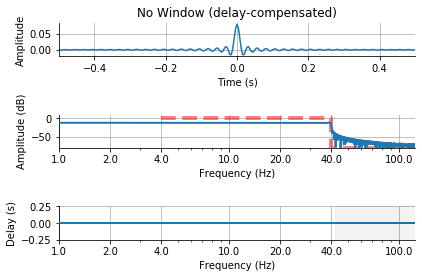

In [0]:
from mne.viz import plot_filter, plot_ideal_filter
import matplotlib.pyplot as plt

sfreq = 250
f_p = 40.
nyq = sfreq / 2.  # the Nyquist frequency is half our sample rate
freq = [0, f_p, f_p, nyq]
gain = [1, 1, 0, 0]

n = int(round(1 * sfreq))
n -= n % 2 - 1  # make it odd
t = np.arange(-(n // 2), n // 2 + 1) / sfreq  # center our sinc
h = np.sinc(2 * f_p * t) / (4 * np.pi)
flim = (1., sfreq / 2.)
fig = plot_filter(h, sfreq, freq, gain, 'No Window', flim=flim, compensate=True)

textstr = '\n'.join((
    'Pass-band Frequency: '+str(f_p),
    'Filter Length: 1s'))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
fig.text(0.7, 0.9, textstr, fontsize=14, bbox=props)

plt.show()
fig.savefig('ringing_40hz.png')

To avoid such ringing, a number of methods can be used; with the most common being a *windowed* FIR design. This means we create a transition band between the pass band (e.g. 40Hz) and the stop frequency (e.g. 50Hz). Furthermore, the shorter the filter, the wider the transition band should be to avoid ringing effects.

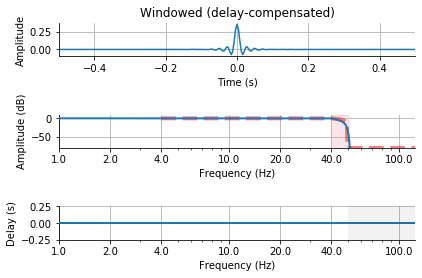

In [0]:
from scipy import signal
trans_bandwidth = 10  # 10 Hz transition band
f_s = f_p + trans_bandwidth

freq = [0., f_p, f_s, nyq]
gain = [1., 1., 0., 0.]
h = signal.firwin2(n, freq, gain, nyq=nyq)
fig = plot_filter(h, sfreq, freq, gain, 'Windowed',
                  flim=flim, compensate=True)

textstr = '\n'.join((
    'Pass-band Frequency: '+str(f_p),
    'Filter Length: 1s',
    'Transition Bandwidth: '+str(trans_bandwidth)+' Hz'))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
fig.text(0.7, 0.88, textstr, fontsize=14, bbox=props)

plt.show()
fig.savefig('no_ringing_40hz.png')

Lets have a look at how a filter alike to the one above changes an EEG segment with some noise in.

Creating RawArray with float64 data, n_channels=23, n_times=400250
    Range : 0 ... 400249 =      0.000 ...  1600.996 secs
Ready.


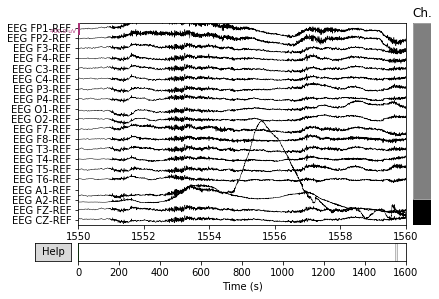

In [0]:
import mne

def mne_object(data, freq):
  # create an mne info file with meta data about the EEG
  info = mne.create_info(ch_names=list(data.columns), 
                         sfreq=freq, 
                         ch_types=['eeg']*data.shape[-1])
  
  # data needs to be in volts rather than in microvolts
  data = data.apply(lambda x: x*1e-6)
  # transpose the data
  data_T = data.transpose()
  
  # create raw mne object
  raw = mne.io.RawArray(data_T, info)

  return raw

tuh_mne = mne_object(seiz_df, seiz_freq)

plot = tuh_mne.plot(scalings = dict(eeg=20e-5),
                    start = 1550,
                    duration = 10,
                    show =True,
                    show_scrollbars=False)

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165 samples (0.660 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165 samples (0.660 sec)



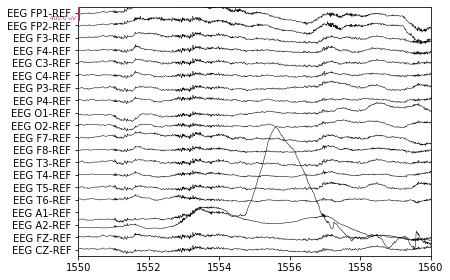

In [0]:
sfreq = tuh_mne.info['sfreq']
l_freq = None
h_freq = 40
method = 'fir'
fir_design = 'firwin2'

filter_params = mne.filter.create_filter(tuh_mne.get_data(), sfreq,
                                         l_freq=l_freq, h_freq=h_freq, 
                                         fir_design=fir_design)

filt_data = tuh_mne.filter(l_freq, h_freq,
                           method=method, 
                           fir_design=fir_design)

plot = filt_data.plot(scalings = dict(eeg=20e-5),
                      start = 1550,
                      duration = 10,
                      show =True,
                      show_scrollbars=False)

## IIR Filters

They are so named as is a single pulse was used as the input, an IIR filter could output a signal continuously. 

Alike to FIR filters, it computes a weighted sum of input samples, but also adds a weighted sum of the previous *output* samples<sup>1</sup>. For IIR filters, both the attenuation and delay depend upon the cutoff frequency, however this also leads to differences in phase delay; with low-frequency signals typically delayed more than high-frequency signals. 

Two common IIR filters are Butterworth and Elliptic filters.

---
1. Meddins2000

Butterworth
Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB



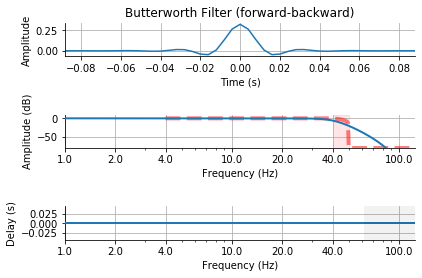

Elliptic
Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
elliptic lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -0.00 dB



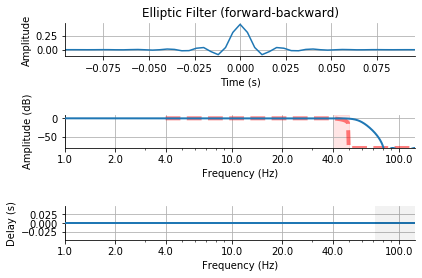

In [0]:
import mne

print(color.BOLD+color.UNDERLINE+'Butterworth'+color.END)
iir_params = dict(order=4, ftype='butter')
filt = mne.filter.create_filter(tuh_mne.get_data(), sfreq, l_freq=None, h_freq=f_p,
                                method='iir', iir_params=iir_params,
                                verbose=True)
fig=plot_filter(filt, sfreq, freq, gain, 'Butterworth Filter', flim=flim,
                compensate=True)

plt.show()

print(color.BOLD+color.UNDERLINE+'Elliptic'+color.END)

iir_params = dict(order=4, ftype='elliptic', rp=0.0025, rs=40)
filt = mne.filter.create_filter(tuh_mne.get_data(), sfreq, l_freq=None, h_freq=f_p,
                                method='iir', iir_params=iir_params,
                                verbose=True)

fig=plot_filter(filt, sfreq, freq, gain, 'Elliptic Filter', flim=flim,
                compensate=True)

## Artefacts

**TODO**
- Write a section on artefacts and the effects of filtering on them

# Feature Engineering

Key to the performance of any machine learning algorithm is the successful extraction of salient features, which can come from both domain knowledge and computational feature extraction techniques<sup>1</sup>. Therefore the start of any machine learning project is to identify relevant features from knowledge of the data, in this case time-series, or the previous literature on that domain. 

For my own research I extracted a number of features specific to the type of epilepsy I worked on. This tutorial will go over a few of the features that were the easiest to extract.

---
1. REF

## Fourier Transform

As EEG contains events that occur at different overlapping frequencies, subspectral components of an EEG signal are often separated and processed discretely, allowing for the decomposition of the signal into frequency bands. To describe a signal in terms of its the frequency components, the data can be transformed by projecting it onto sinusoidal basis functions; with this transformation from the time domain to the frequency domain known as a Fourier transform<sup>1</sup>. Fourier transforms measure oscillation amplitude independent of phase, meaning latency variation can be avoided<sup>2</sup>. Short-time Fourier transformation’s (STFT), which windows the EEG signal and applies a fast Fourier transformation to each data frame<sup>3</sup>, are often applied to EEG data. 

Although broadly used, it is worth noting that Fourier transforms can loose temporal information from data due to stretching the signal to fit onto sine waves<sup>4</sup>, and the same window size is used to calculate power in different frequencies despite low and high frequencies yielding greater precision with different window sizes<sup>2</sup>. Indeed, the width of the ‘window’ used on the data is important as it can result in poor frequency resolution if too narrow, or poor time localisation that violates the stationarity assumption if too wide<sup>1,5</sup>.

---

1. Varsavsky, A., Mareels, I., & Cook, M. (2011). EEG Generation and Measurement. In Epileptic seizures eeg meas. model. detect. predict. (Chap. 2, p. 337). doi:doi:10.1201/b10459-3
2. Luck2014a
3. Kiymik, M. K., Güler, I., Dizibüyük, A., & Akin,M. (2005). Comparison of STFT and wavelet transform methods in determining epileptic seizure activity in EEG signals for real-time application. Comput. Biol. Med. 35(7), 603–616.
4. Luck2014b
5. Rosso, O. A., Martin, M. T., Figliola, A., Keller, K., & Plastino,A. (2006). EEG analysis using wavelet-based information tools. J. Neurosci. Methods, 153(2), 163–182.

### Spectrogram

**TODO**
- write about spectrograms
- Convert code from methods chapter to work here

### Periodogram

**TODO**
- write about periodograms
- write some code to demonstrate

### Welch

Now lets look at how we use the Welch method to gain a spectral estimation of a signal.

The Welch method is related to a Short-time Fourier transform in that it is a spectral density estimation method that calculates a periodogram for windowed sections of data. Overlapping segments are windowed, as this helps mitagate the loss of information at the edges of the time window, with a discrete Fourier transform applied to calculate the periodogram. Data is squared and each periodogram averaged to reduce the variance of each power measure.

The Welch method is a common and easy method to apply in both Matlab and Python. In Python we can use scipy to get out the power spectral density.

__NOTES__
- The code I wrote below will not work with frequencies below 1hz IF we are using 2 second windows because want want at least 2 cycles of each frequency (e.g. for 0.5Hz you'd need a 4 second window).

In [0]:
from scipy.signal import welch
sample_rate = 173.61 # in hz

# specify the lowest frequency your interested in
low = 8

# this is the window size and ensures there are at least 2 cycles 
# of the lowest frequency in the window
nperseg = (2 / low)*sample_rate

# Compute the periodogram (Welch)
freqs, psd = welch(baseline_df, 
                   sample_rate, 
                   nperseg=nperseg,
                   scaling='density', 
                   axis=0)

# put into a df
psd = pd.DataFrame(psd, index = freqs, columns = baseline_df.columns)

print(color.BOLD+'Welch Output'+color.END)
psd.index.name = 'Hz'
psd.columns = ['Power']
display(psd)

Welch Output


,Power
Hz,
0.000000,889.360582
4.037442,5683.980504
8.074884,2434.988822
12.112326,840.116911
16.149767,468.925355
20.187209,200.082613
24.224651,68.433595
28.262093,27.860948
32.299535,19.928694


Now we will just select the frequency range we are interested in from this output and get a mean value

In [0]:
import numpy as np

# specify the higest frequency your interested in
high = 12

# Find closest indices of band in frequency vector
idx_min = np.argmax(np.round(freqs) > low) - 1
idx_max = np.argmax(np.round(freqs) > high)

# select frequencies of interest
psd = psd.iloc[idx_min:idx_max,:]

# get the mean of each channel over all frequencies in the band
psd = psd.mean()

print(color.BOLD+'\nMean Frequency Band'+color.END)
display(psd)


Mean Frequency Band


Power    1637.552866
dtype: float64

Lets now tie both parts into a function

In [0]:
%%time
from scipy.signal import welch
import numpy as np

def bandpower(data, sf, band, output = False):
    band = np.asarray(band)
    low, high = band

    # Compute the periodogram (Welch)
    freqs, psd = welch(data, 
                       sf, 
                       nperseg=(2 / low)*sf,
                       scaling='density', 
                       axis=0)
    
    # put into a df
    psd = pd.DataFrame(psd, index = freqs, columns = data.columns)
    
    if output:
        print(color.BOLD+'Welch Output'+color.END)
        psd.index.name = 'Hz'
        psd.columns = ['Power']
        display(psd)
    
    # Find closest indices of band in frequency vector
    idx_min = np.argmax(np.round(freqs) > low) - 1
    idx_max = np.argmax(np.round(freqs) > high)
    
    # select frequencies of interest
    psd = psd.iloc[idx_min:idx_max,:]
    
    # get the mean of each channel over all frequencies in the band
    psd = psd.mean()
    
    if output:
        print(color.BOLD+'\nMean Frequency Band'+color.END)
        display(psd)
    
    return psd

baseline_power = bandpower(baseline_df, sample_rate, [8,12], output=False)

CPU times: user 1.96 ms, sys: 0 ns, total: 1.96 ms
Wall time: 1.96 ms


Now we want to get mean values for multipule frequency bands, so we will make a function that uses the previous function in order to get these values.

In [0]:
def power_measures(data, output=False):
    bandpasses = [[[0.1,4],'power_delta'],
                  [[4,8],'power_theta'],
                  [[8,12],'power_alpha'],
                  [[12,30],'power_beta'],
                  [[30,70],'power_gamma']
                 ]
    
    welch_df = pd.DataFrame()
    for bandpass, freq_name in bandpasses:
        bandpass_data = bandpower(data, sample_rate, bandpass)
        bandpass_data.index = [freq_name]
        
        if welch_df.empty:
            welch_df = bandpass_data

        else:
            welch_df = pd.concat([welch_df, bandpass_data])
        
    welch_df = welch_df.T
    
    if output:
        display(welch_df)
    
    return welch_df

print(color.BOLD+color.UNDERLINE+'Baseline Mean Power'+color.END)
baseline_power = power_measures(baseline_df, output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Mean Power'+color.END)
seizure_power = power_measures(seizure_df, output=True)

Baseline Mean Power


power_delta    18864.764238
power_theta     4398.892010
power_alpha     1637.552866
power_beta       461.728763
power_gamma      124.460181
dtype: float64


Seizure Mean Power


power_delta     9811.958106
power_theta    14371.740718
power_alpha     5207.634127
power_beta      1088.598329
power_gamma      265.594331
dtype: float64

Now lets modify this to make it work for more than 1 channel so we can use it with the TUH data

In [0]:
%%time
def power_measure_channels(data, freq, output=False):

  welch_df = pd.DataFrame()
  for channel_name in data:
    channel_df = pd.DataFrame(power_measures(pd.DataFrame(data[channel_name])))
    channel_df['channel'] = channel_name
    channel_df.index.name = 'feature'
    channel_df = channel_df.set_index('channel', append=True)
    channel_df = channel_df.swaplevel()

    if welch_df.empty:
        welch_df = channel_df
    else:
        welch_df = pd.concat([welch_df, channel_df])

  welch_df = welch_df.T

  if output:
    display(welch_df.head())
    
  return welch_df

example_power_measure = power_measure_channels(seiz_df, 
                                               seiz_freq, 
                                               output=True)

channel EEG FP1-REF                          ...  EEG T2-REF                       
feature power_delta power_theta power_alpha  ... power_alpha power_beta power_gamma
0        667.395217  129.775243   54.145163  ...   45.048349  10.559601    4.024451

[1 rows x 115 columns]

CPU times: user 4.02 s, sys: 29.1 ms, total: 4.05 s
Wall time: 4.06 s


## Wavelet Transform

Another common spectral analysis approach is a wavelet transformation (WT). 

Wavelets can be used to analyse time series with nonstationary power at different frequency bands<sup>3</sup>, express discontinuities caused by recording apparatus<sup>5</sup>, and are useful for identifying and removing artefacts<sup>6,7,8</sup>. 

Several oscillatory kernel-based wavelets are projected onto a signal, dividing the data into different frequency components which are each analysed in respect to their scale<sup>1,2,3</sup>. A 'family' wavelet is a group of functions that is defined by stretching or shrinking a wavelet (dilation) and moving the wavelet to different positions in time (translation)<sup>4</sup>.

Many families exist as can be seen below.
    
---

1. Kiymik, M. K., Güler, I., Dizibüyük, A., & Akin, M. (2005). Comparison of STFT and wavelet transform methods in determining epileptic seizure activity in EEG signals for real-time application. Computers in Biology and Medicine, 35(7), 603–616. https://doi.org/10.1016/j.compbiomed.2004.05.001
2. Sakkalis, V., Cassar, T., Zervakis, M., Camilleri, K. P., Fabri, S. G., Bigan, C., … Micheloyannis, S. (2008). Parametric and nonparametric EEG analysis for the evaluation of EEG activity in young children with controlled epilepsy. Computational Intelligence and Neuroscience, 2008. https://doi.org/10.1155/2008/462593
3. Sakkalis, V., Zervakis, M., & Micheloyannis, S. (2006). Significant EEG features involved in mathematical reasoning: Evidence from wavelet analysis. Brain Topography, 19(1–2), 53–60. https://doi.org/10.1007/s10548-006-0012-z
4. Rosso, O. A., Martin, M. T., Figliola, A., Keller, K., & Plastino, A. (2006). EEG analysis using wavelet-based information tools. Journal of Neuroscience Methods, 153(2), 163–182. https://doi.org/10.1016/j.jneumeth.2005.10.009
5. Akin, M., & Kiymik, M. K. (2000). Application of periodogram and AR spectral analysis to EEG signals. Journal of Medical Systems, 24(4), 247–256. https://doi.org/10.1023/A:1005553931564
6. Khatun, S., Mahajan, R., & Morshed, B. I. (2016). Comparative Study of Wavelet-Based Unsupervised Ocular Artifact Removal Techniques for Single-Channel EEG Data. IEEE Journal of Translational Engineering in Health and Medicine, 4(December 2015). https://doi.org/10.1109/JTEHM.2016.2544298
7. Mammone, N., & Morabito, F. C. (2014). Enhanced automatic wavelet independent component analysis for electroencephalographic artifact removal. Entropy, 16(12), 6553–6572. https://doi.org/10.3390/e16126553
8. Olund, T., Duun-Henriksen, J., Kjaer, T. W., & Sorensen, H. B. D. (2014). Automatic detection and classification of artifacts in single-channel EEG. 2014 36th Annual International Conference of the IEEE Engineering in Medicine and Biology Society, EMBC 2014, 922–925. https://doi.org/10.1109/EMBC.2014.6943742

In [0]:
from pywt import families

families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

### Discrete Wavelet Transform

Lets start by looking at a simple Haar wavelet.

**TODO**
- add brief description of what makes it discrete

In [0]:
from pywt import Wavelet

wavelet = Wavelet('Haar')
print(wavelet)

Wavelet haar
  Family name:    Haar
  Short name:     haar
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


As can be seen below, this appears as a square wave. Essentally a Haar transform just cross-multiplies a function against this wave with various shifts and stretches in time.

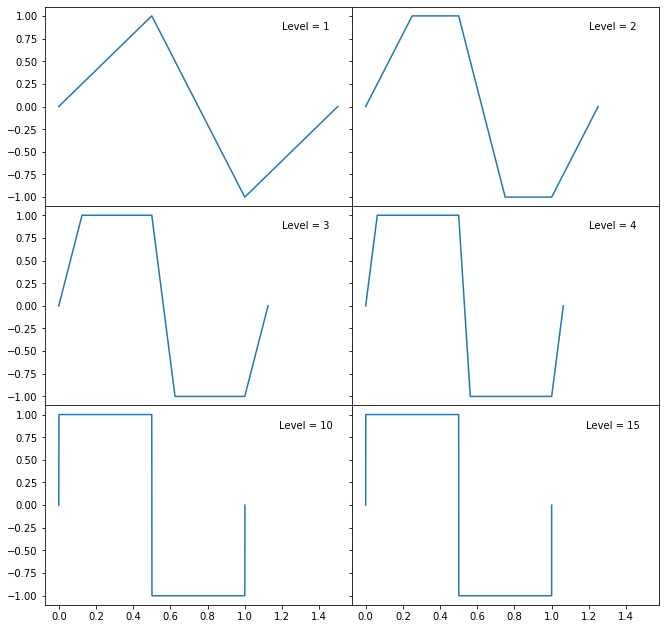

In [0]:
import matplotlib.pyplot as plt

def plot_wavelet(wavelet):

    fig, axs = plt.subplots(3,2, figsize=(11,11), squeeze =True, sharex=True, sharey=True)
    axs = axs.flatten()
    for i, level in enumerate([1, 2, 3, 4, 10, 15]):
        try:
            [psi, x] = wavelet.wavefun(level=level)
        except:
            [phi, psi, x] = wavelet.wavefun(level=level)
        axs[i].plot(x, psi)
        axs[i].text(0.85, 0.9, "Level = "+str(level), ha='center', va='center', transform=axs[i].transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

plot_wavelet(wavelet)

The Daubechies 4 wavelet (db4) is the most commonly used wavelet for EEG and epilepsy seizure detection as it is smooths the frequency filtering enough to characterise the EEG, but is also computationally efficient<sup>1,2,3</sup>.

---
1. Kjær, T. W., Sorensen, H. B. D., Groenborg, S., Pedersen, C. R., & Duun-Henriksen, J. (2017). Detection of Paroxysms in Long-Term, Single Channel EEG-Monitoring of Patients with Typical Absence Seizure. IEEE Journal of Translational Engineering in Health and Medicine, 5(September 2016). https://doi.org/10.1109/JTEHM.2017.2649491
2. Subasi, A. (2007). EEG signal classification using wavelet feature extraction and a mixture of expert model. Expert Systems with Applications, 32(4), 1084–1093. https://doi.org/10.1016/j.eswa.2006.02.005
3. Adeli, H., Zhou, Z., & Dadmehr, N. (2003). Analysis of EEG records in an epileptic patient using wavelet transform. Journal of Neuroscience Methods, 123(1), 69–87. https://doi.org/10.1016/S0165-0270(02)00340-0

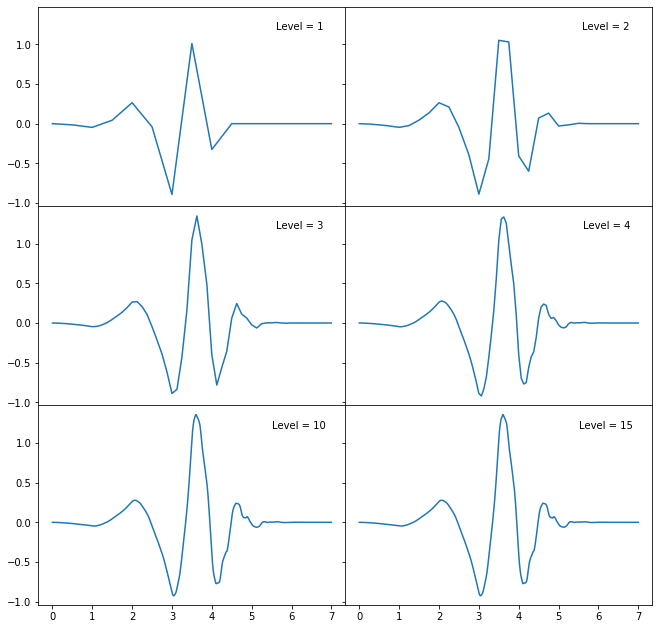

In [0]:
plot_wavelet(Wavelet('db4'))

Now lets get the list of arrays out, each represeting the coefficients at a specific level. Now I am using a 'decimated' transform here so the length of data going in is different to the length out.

__Decimation at 173.61hz with a Daubechies 4 wavelet__

- D1: 43.40 - 86.805 (Gamma)

- D2: 21.7 - 43.40 (Beta/Gamma)

- D3: 10.85 - 21.7 (Beta)

- D4: 5.43 - 10.85 (Alpha)

- D5: 2.71 - 5.43 (Theta)

- D6: 1.36 - 2.71 (Delta)

- A6: >1.36 (Delta/DC)

In [0]:
from pywt import wavedec

# number of levels we are interested in
level = 6

# transpose the data because its a time-series package
data_t = baseline_df.transpose()

# get the wavelet coefficients at each level in a list
coeffs_list = wavedec(data_t.values, wavelet='db4', level=level)

print(type(coeffs_list))
print(color.BOLD+color.UNDERLINE+'\nExample first array'+color.END)
coeffs_list[0]

<class 'list'>

Example first array


array([[ 1181.70402535,  1222.31934684,  1186.58114564,  1119.30615032,
         1604.0324783 ,    25.89019047,  1780.72838765,  -973.90578049,
         1220.89183062,  1293.42816916,   969.47947677,  -157.9270515 ,
         -563.78624385,  -932.26288111,    -9.97373656, -1153.16884245,
         -388.46627896,  -978.83447438,   825.79767601, -2068.52191341,
         -902.76616695,  -907.06309716,    33.94486868,  -323.56923264,
        -1303.9367751 ,   341.99794327, -1239.81391063, -1374.40588055,
         2176.67574815,  -873.9977607 ,   136.07105931,  -576.83053461,
        -1754.71926172, -1129.91038679,  2414.20323465,  2157.9675786 ,
         2817.67685717,  -206.68406909,   418.16443435,  2386.0601948 ,
          686.29657472, -1793.06453077,  2091.92878426, -1253.63309753,
         -921.75978608, -2782.32520904,    44.8599721 , -2744.14365319,
          685.7713572 ,   444.34853778,  -540.8882925 ,  -131.68367604,
           15.37213474,  1753.78765896, -1375.40957813,  1227.31

Lets make a list of the names of the coefficients (the name of each array in the list).

In [0]:
# make a list of the component names (later column rows)
nums = list(range(1,level+1))
names=[]
for num in nums:
    names.append('D' + str(num))
names.append('A' + str(nums[-1]))

# reverse the names so it counts down
names = names[::-1] 

names

['A6', 'D6', 'D5', 'D4', 'D3', 'D2', 'D1']

Now lets turn the arrays into dataframes and use these names as the header.

In [0]:
# make an empty dataframe
wavelets = pd.DataFrame()

# for each array in the list of arrays
for i, array in enumerate(coeffs_list):
    # turn into a dataframe and transpose
    level_df = pd.DataFrame(array).T
    # name the column the appropriate level name
    level_df.columns = [names[i]]
    # if the wavelets df is empty...
    if wavelets.empty:
        # ... make the first level df the wavelets df
        wavelets = level_df
    # ..otherwise...
    else:
        # ... add the next levels df to another column
        wavelets = pd.concat([wavelets,level_df], axis=1)

wavelets.head()

,A6,D6,D5,D4,D3,D2,D1
0,1181.704025,-2.681982,0.645221,0.762090,-13.145503,-2.082229,1.034561
1,1222.319347,-3.841698,4.815476,5.851161,-40.035244,-7.686451,2.091650
2,1186.581146,101.168531,124.613694,49.381880,40.524474,6.152228,3.416285
3,1119.306150,-1546.522140,260.010805,-126.090877,23.713159,0.368236,18.439460
4,1604.032478,-1840.435598,443.348137,66.655876,59.011389,1.185516,5.938704


You may be wondering what the difference is between the A and the D's. Well the A stands for the "*approximation coefficient*" and the D "*detail coefficient*". The detail coefficients come from high-pass filters applied to the data and approximation coefficients from the low-pass. A series of these filters are applied, each time the output of the low-pass filter is subsampled by 2 and further processed by passing it again through a new low-pass filter and a high-pass filter with half the cut-off frequency of the previous one. 

A discrete transform reduces the output so, although there are multipule approximation coefficient's during calculation, we only get the last one which for our purpose contains information about the rest of the frequencies below the ones covered by the detail coefficients.

For EEG, really fast frequencies below 1Hz are not often used so we will just get rid of the A column for now.

In [0]:
# remove the AN levels
regex = re.compile('D')
bad_items = [x for x in list(wavelets.columns) if not regex.match(x)]
decom_wavelets = wavelets.drop(bad_items, axis=1)

decom_wavelets.head()

,D6,D5,D4,D3,D2,D1
0,-2.681982,0.645221,0.762090,-13.145503,-2.082229,1.034561
1,-3.841698,4.815476,5.851161,-40.035244,-7.686451,2.091650
2,101.168531,124.613694,49.381880,40.524474,6.152228,3.416285
3,-1546.522140,260.010805,-126.090877,23.713159,0.368236,18.439460
4,-1840.435598,443.348137,66.655876,59.011389,1.185516,5.938704


Lets take everything we have done so far and now put it in a function

**NOTE**
- for the purposes of visualisation I am going to trim the last datapoint off before running it through the function. This is so the number of data is even which makes things a lot easier.

In [0]:
%%time

def wavelet_decompose(data, output=False):
    
    # decompose data into coefficients
    level = 6

    # return the frequencies
    frequencies = np.array([seiz_freq]*level)
    j = [1<<exponent for exponent in range(level)]
    frequencies = frequencies/j
    
    # transpose the data
    data_t = data.transpose()
    
    # get the wavelet coefficients at each level in a list
    coeffs_list = wavedec(data_t.values, wavelet='db4', level=level, mode='per')

    # make a list of the component names (later column rows)
    nums = list(range(1,level+1))
    names=[]
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[-1]))
    
    # reverse the names so it counts down
    names = names[::-1] 
    
    # make an empy dataframe
    wavelets = pd.DataFrame()
    
    # for each array in the list of arrays
    for i, array in enumerate(coeffs_list):
        # turn into a dataframe and transpose
        level_df = pd.DataFrame(array).T
        # name the column the appropriate level name
        level_df.columns = [names[i]]
        # if the wavelets df is empty...
        if wavelets.empty:
            # ... make the first level df the wavelets df
            wavelets = level_df
        # ..otherwise...
        else:
            # ... add the next levels df to another column
            wavelets = pd.concat([wavelets,level_df], axis=1)
    
    # remove the AN levels
    regex = re.compile('D')
    bad_items = [x for x in list(wavelets.columns) if not regex.match(x)]
    decom_wavelets = wavelets.drop(bad_items, axis=1)
    
    if output:
        display(decom_wavelets.head())
    
    return decom_wavelets, frequencies

print(color.BOLD+color.UNDERLINE+'Baseline Wavelets'+color.END)
baseline_wavelets, frequencies = wavelet_decompose(baseline_df.iloc[:-1], output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Wavelets'+color.END)
seizure_wavelets, frequencies = wavelet_decompose(seizure_df.iloc[:-1], output=True)

Baseline Wavelets


,D6,D5,D4,D3,D2,D1
0,-1273.602570,-105.529467,-411.084913,-76.666336,-58.264662,2.594395
1,-1901.927267,-527.481613,233.724596,-27.684363,33.707564,-15.448868
2,-116.482456,144.051343,-194.748234,-52.546593,-17.441654,-11.257192
3,-47.260208,122.352150,1307.087703,64.925132,30.353437,13.965831
4,-2056.561156,-1192.531728,-630.414718,88.967453,-2.354381,22.606331



Seizure Wavelets


,D6,D5,D4,D3,D2,D1
0,77.459769,-2201.499253,-158.072735,81.904482,17.369233,-1.235788
1,84.452880,-473.377303,592.446067,-693.510413,3.005205,-0.680125
2,-42.688829,996.665622,-65.619967,309.412207,-12.285318,-0.702219
3,92.475661,2004.550368,-76.338451,16.967975,82.103411,-3.117101
4,-347.099179,-1154.230952,-272.987001,-59.487952,-17.700552,8.254308


CPU times: user 49.6 ms, sys: 869 µs, total: 50.4 ms
Wall time: 53.2 ms


Before moving on, lets have a look at a visual representation of the above data using a scalogram. A scalagram is the absolute value of the output of a wavelet transform. It is similar to the spectogram we saw before.

**NOTES**
- These are typically more associated with continuous wavelet transforms where they provide "*...better time localization for short-duration, high-frequency events, and better frequency localization for low-frequency, longer-duration events [than spectrograms]*"<sup>1</sup>

---
1. https://uk.mathworks.com/help/signal/ug/scalogram-computation-in-signal-analyzer.html

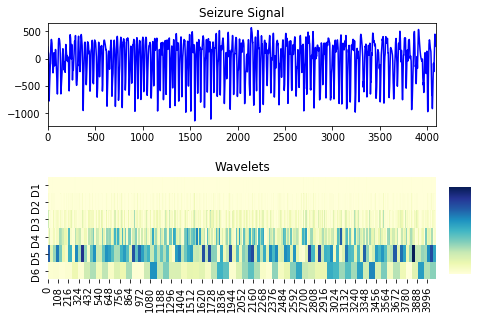

[250.     125.      62.5     31.25    15.625    7.8125]


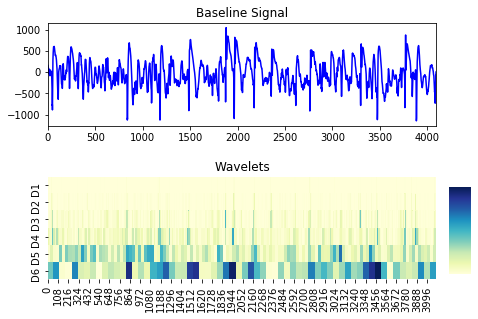

[250.     125.      62.5     31.25    15.625    7.8125]


In [0]:
import seaborn as sns

def plot_dwt_scalogram(signal, wt_data, frequencies, interpolation, class_name):
  
  cmap = plt.cm.cool
  x = range(len(signal))
  
  # Show signal and wavelet packet coefficients
  fig, (sig_ax, spec_ax) = plt.subplots(2)
  fig.subplots_adjust(hspace=0.5, bottom=.03, left=.07, right=.97, top=.92)
  
  # plot the signal
  sig_ax.set_title(class_name + " Signal")
  sig_ax.plot(x, signal, 'b')
  sig_ax.set_xlim(0, x[-1])

  exponent_list = [2<<exponent for exponent in range(wt_data.shape[1]+1)]
  wt_data_ = wt_data.copy()
  for i, decom in enumerate(wt_data.sort_index(1).columns):
    exponent_data = wt_data_[decom].dropna().repeat(exponent_list[i]).reset_index(drop=True)
    if i == 0:
      plot_data = pd.DataFrame(exponent_data.abs(), 
                               columns =[decom])
    else:
      plot_data = pd.concat([plot_data, pd.DataFrame(exponent_data.abs(), columns =[decom])], axis=1)
  
  # plot the spectrogram
  cbar_ax = fig.add_axes([1, 0.05, 0.05, 0.3])
  spec_ax.set_title("Wavelets")
  sns.heatmap(plot_data.T, ax=spec_ax, cmap="YlGnBu", cbar_ax=cbar_ax, 
              cbar_kws={"ticks":[]}
              )
  
  plt.show()
  print(frequencies)

plot_dwt_scalogram(seizure_df, 
               seizure_wavelets, 
               frequencies, None, 'Seizure')

plot_dwt_scalogram(baseline_df, 
               baseline_wavelets, 
               frequencies, None, 'Baseline')

Now lets make some minor changes so it works with data with more than 1 channel

In [0]:
from pywt import wavedec

def wavelet_decompose_channels(data, level, output=False):
  # take every x number of points using numpy's slicing (start:stop:step)
  data = data[0::2]

  data.columns.name='channel'

  # transpose the data
  data_t = data.transpose()

  # get the wavelet coefficients at each level in a list
  coeffs_list = wavedec(data_t.values, wavelet='db4', level=level)

  # make a list of the component names (later column rows)
  nums = list(range(1,level+1))
  names=[]
  for num in nums:
    names.append('D' + str(num))
  names.append('A' + str(nums[-1]))

  # reverse the names so it counts down
  names = names[::-1]  

  i = 0
  wavelets = pd.DataFrame()
  for i, array in enumerate(coeffs_list):
    # turn into a dataframe and transpose
    level_df = pd.DataFrame(array)
    level_df.index = data.columns
    level_df['level'] = names[i]
    level_df= level_df.set_index('level', append=True)
    level_df=level_df.T
    # add the next levels df to another column
    wavelets = pd.concat([wavelets,level_df], axis=1, sort=True)

  # sort values along the channels
  wavelets = wavelets.sort_values(['channel', 'level'], axis=1)

  # remove the AN levels
  regex = re.compile('D')
  bad_items = [x for x in list(wavelets.columns.levels[1]) if not regex.match(x)]
  decom_wavelets = wavelets.drop(bad_items, axis=1, level = 'level')

  decom_wavelets.index.name='sample'

  if output:
    display(decom_wavelets.head())

  return decom_wavelets

example_wavelets = wavelet_decompose_channels(seiz_df, level=5, output=True)

channel   EEG A1-REF               ...   EEG T6-REF             
level             D1           D2  ...           D4           D5
sample                             ...                          
0          -0.246493     7.473306  ...    -8.028176    27.278256
1          -0.559206    17.004884  ...   -41.323443   224.762601
2           1.076321    61.667724  ...   766.376027  3676.790720
3          65.272934  2208.515015  ... -5705.888392 -7952.029633
4        1233.859721   522.366321  ...  2329.103390  3699.779567

[5 rows x 115 columns]

#### DWT Features

There are 5 features that come from the wavelet transform that I will focus on in this tutorial from the DWT:
- Kjær et al. (2016)<sup>4</sup>
    - Log-Sum of the wavelet transform
- Subasi (2007)<sup>6</sup>
    - Mean of the absolute values of the coefficients in each sub-band
    - Average power of the wavelet coefficients in each sub-band
    - Standard deviation of the coefficients in each sub-band
    - Ratio of the absolute mean values of adjacent sub-bands

We are going to look at each on both the 1 channel data and multi-channel data.

**Log Sum**

The log sum of the wavelet coefficients is a common method<sup>1,2,3,4</sup> in the seizure detection literature to create a feature for the machine learning method. The detail coefficents without futher processing can be sensitive to noise, therefore Shoeb et. al. (2004) suggested applying the log-sum energy of the subband coefficients as features. 

The log transform is a power transform which change the distribution of a variable so that the variance is no longer dependent on the mean. The log function maps a range of numbers to a smaller range by compressing large numbers and expanding the range of small numbers. For example log10(x) maps the range of [1, 10] to [0, 1], [10, 100] to [1, 2]. The log is particularly useful where there is a heavy-tailed distribution because it compresses the long tail at the high end of the distribution and extends the low tail<sup>5</sup>. 

**NOTES**
- to make sure there are no negative numbers before the log transform we minus the smallest minus number from all data +1 so that the smallest number is 0 after the transform.

---

1. Shoeb, A., Edwards, H., Connolly, J., Bourgeois, B., Ted Treves, S., & Guttag, J. (2004). Patient-specific seizure onset detection. Epilepsy & Behavior, 5(4), 483–498. https://doi.org/10.1016/j.yebeh.2004.05.005
2. Petersen, E. B., Duun-Henriksen, J., Mazzaretto, A., Kjar, T. W., Thomsen, C. E., & Sorensen, H. B. D. (2011). Generic single-channel detection of absence seizures. Proceedings of the Annual International Conference of the IEEE Engineering in Medicine and Biology Society, EMBS, 4820–4823. https://doi.org/10.1109/IEMBS.2011.6091194
3. J. Duun-Henriksen, R. E. Madsen, L. S. Remvig, C. E. Thomsen, H. B. D. Sorensen, and T. W. Kjaer, ‘‘Automatic detection of childhood absence epilepsy seizures: Toward a monitoring device,’’ Pediatric Neurol., vol. 46, no. 5, pp. 287–292, 2012.
4. Kjær, T. W., Sorensen, H. B. D., Groenborg, S., Pedersen, C. R., & Duun-Henriksen, J. (2017). Detection of Paroxysms in Long-Term, Single Channel EEG-Monitoring of Patients with Typical Absence Seizure. IEEE Journal of Translational Engineering in Health and Medicine, 5(September 2016). https://doi.org/10.1109/JTEHM.2017.2649491
5. Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. " O'Reilly Media, Inc.".
6. Subasi, A., Kevric, J., & Abdullah Canbaz, M. (2017). Epileptic seizure detection using hybrid machine learning methods. Neural Computing and Applications, 1–9. https://doi.org/10.1007/s00521-017-3003-y

In [0]:
def minus_small(data):    
  # find the smallest value for each data column (channel)...
  min_val = data.min()
  # ...and subtract it from all the data in the column and add one
  data = data.subtract(min_val).add(1)

  return data

def log_sum(data, output=False):
    absolute_sums = data.sum()
    # ...and subtract it from all the data in the column and add one
    absolute_sums_minus = minus_small(absolute_sums)
    # find the log of each elecment (datapoint)
    absolute_sums_log = absolute_sums_minus.apply(np.log)
    absolute_sums_log.index += '_LSWT'
    
    if output:
        display(absolute_sums_log)
    
    return absolute_sums_log
    
print(color.BOLD+color.UNDERLINE+'Baseline Log Sum Wavelets'+color.END)
baseline_LSWT = log_sum(baseline_wavelets, output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Log Sum Wavelets'+color.END)
seizure_LSWT = log_sum(seizure_wavelets, output=True)

Baseline Log Sum Wavelets


D6_LSWT    0.000000
D5_LSWT    9.286775
D4_LSWT    8.533138
D3_LSWT    8.726400
D2_LSWT    8.901572
D1_LSWT    8.799604
dtype: float64


Seizure Log Sum Wavelets


D6_LSWT    10.127994
D5_LSWT     0.000000
D4_LSWT    10.007185
D3_LSWT     9.042248
D2_LSWT     9.245858
D1_LSWT     9.247858
dtype: float64

... now lets modify above so it works on multipule channels

In [0]:
def reformat(data, feature_name):
  data.index = [feature_name+level for level in data.index]
  data.index.name = 'feature'
  data = pd.DataFrame(data.unstack()).T

  return data

def log_sum_channels(data, output=False):
  absolute_sums = data.sum()
  # make the columns channels
  absolute_sums = absolute_sums.unstack('channel')
  # for each channel apply the minus small function
  absolute_sums_minus = absolute_sums.apply(minus_small)
  # find the log of each channel
  absolute_sums_log = absolute_sums_minus.apply(np.log)
  # reformat the df for later combination with other features
  absolute_sums_log = reformat(absolute_sums_log, 'LSWT_')

  if output:
    display(absolute_sums_log.head())

  return absolute_sums_log
    
example_absolute_sums_log = log_sum_channels(example_wavelets, output=True)

channel EEG A1-REF                      ... EEG T6-REF                   
feature    LSWT_D1   LSWT_D2   LSWT_D3  ...    LSWT_D3   LSWT_D4  LSWT_D5
0         8.927022  6.307839  5.763985  ...   7.404454  7.986045  6.62268

[1 rows x 115 columns]

**Average power of the wavelet coefficients in each sub-band**

In [0]:
def ave(data, output=False):
    # get the mean
    mean_data = data.mean()
    
    mean_data.index += '_mean'
    
    if output:
        display(mean_data)
    
    return mean_data
    
print(color.BOLD+color.UNDERLINE+'Baseline Mean Wavelets'+color.END)
baseline_mean = ave(baseline_wavelets, output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Mean Wavelets'+color.END)
seizure_mean = ave(seizure_wavelets, output=True)

Baseline Mean Wavelets


D6_mean   -113.094050
D5_mean     27.775719
D4_mean     -8.432243
D3_mean     -2.100622
D2_mean      0.102043
D1_mean     -0.296584
dtype: float64


Seizure Mean Wavelets


D6_mean    230.193912
D5_mean    -80.474188
D4_mean     46.420352
D3_mean     -3.611205
D2_mean      0.058457
D1_mean      0.039360
dtype: float64

In [0]:
def ave_channels(data, output=False):
  # get the mean
  mean_data = data.mean()

  mean_data = mean_data.unstack('channel')

  mean_data = reformat(mean_data, 'Mean_')

  if output:
      display(mean_data.head())

  return mean_data

example_wavelet_mean = ave_channels(example_wavelets, output=True)

channel EEG A1-REF                      ... EEG T6-REF                    
feature    Mean_D1   Mean_D2   Mean_D3  ...    Mean_D3   Mean_D4   Mean_D5
0         0.067999 -0.003588 -0.016376  ...   0.023377  0.150334 -0.048948

[1 rows x 115 columns]

**Mean of the absolute values of the coefficients in each sub-band**

In [0]:
def mean_abs(data, output=False):
    # get the mean of the absolute values
    mean_abs_data = data.abs().mean()
    
    mean_abs_data.index += '_mean_abs'
    
    if output:
        display(mean_abs_data)
    
    return mean_abs_data
    
print(color.BOLD+color.UNDERLINE+'Baseline Mean Absolute Wavelets'+color.END)
baseline_mean_abs = mean_abs(baseline_wavelets, output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Mean Absolute Wavelets'+color.END)
seizure_mean_abs = mean_abs(seizure_wavelets, output=True)

Baseline Mean Absolute Wavelets


D6_mean_abs    1181.644379
D5_mean_abs     660.597972
D4_mean_abs     280.960459
D3_mean_abs     119.135523
D2_mean_abs      32.615104
D1_mean_abs       6.904362
dtype: float64


Seizure Mean Absolute Wavelets


D6_mean_abs     700.274334
D5_mean_abs    1216.583240
D4_mean_abs     637.978335
D3_mean_abs     200.546928
D2_mean_abs      39.975884
D1_mean_abs       5.371364
dtype: float64

In [0]:
def mean_abs_channels(data, output=False):
  # get the mean of the absolute values
  mean_abs_data = data.abs().mean()

  mean_abs_data = mean_abs_data.unstack('channel')

  mean_abs_data = reformat(mean_abs_data, 'Mean_Abs_')

  if output:
    display(mean_abs_data.head())

  return mean_abs_data
    

example_mean_abs = mean_abs_channels(example_wavelets, output=True)

channel  EEG A1-REF                          ...  EEG T6-REF                        
feature Mean_Abs_D1 Mean_Abs_D2 Mean_Abs_D3  ... Mean_Abs_D3 Mean_Abs_D4 Mean_Abs_D5
0          6.376284    8.092576   18.361675  ...   17.311965   33.921945   31.842066

[1 rows x 115 columns]

**Standard deviation of the coefficients in each sub-band**

In [0]:
def coeff_std(data, output=False):
    # get the standard deviation of the coeficients
    std_data = data.std()
    
    std_data.index += '_std'
    
    if output:
        display(std_data)
    
    return std_data
    
print(color.BOLD+color.UNDERLINE+'Baseline Standard Deviation Wavelets'+color.END)
baseline_std = coeff_std(baseline_wavelets, output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Standard Deviation Wavelets'+color.END)
seizure_std = coeff_std(seizure_wavelets, output=True)

Baseline Standard Deviation Wavelets


D6_std    1449.617725
D5_std     824.775365
D4_std     403.832764
D3_std     210.542003
D2_std      61.329526
D1_std      16.024182
dtype: float64


Seizure Standard Deviation Wavelets


D6_std     840.907751
D5_std    1394.240662
D4_std     785.440416
D3_std     267.335032
D2_std      60.872012
D1_std       8.150676
dtype: float64

In [0]:
def coeff_std_channels(data, output=False):
  # get the standard deviation of the coeficients
  std_data = data.std()

  std_data = std_data.unstack('channel')

  std_data = reformat(std_data, 'STD_')

  if output:
    display(std_data.head())

  return std_data


example_std = coeff_std_channels(example_wavelets, output=True)

channel EEG A1-REF                        ... EEG T6-REF                       
feature     STD_D1     STD_D2     STD_D3  ...     STD_D3     STD_D4      STD_D5
0         12.73135  25.762417  48.535817  ...  46.482077  89.761906  154.970036

[1 rows x 115 columns]

**Ratio of the absolute mean values of adjacent sub-bands**

This one is a bit more difficult to code, purely because you have to account for the first and last band will not have a coefficent either side of them. Thats the only reason there is an if, elif and else in there.

In [0]:
def ratio(data, output=False):
    # get the mean of the absolute values
    data = data.abs().mean()
    # get a list of the index
    decimation_levels = list(data.index)

    ratio_data=pd.Series(index=data.index)
    for level_no in range(0, len(decimation_levels)):
        # for the first decimation
        if level_no == 0:
            ratio_data.loc[decimation_levels[level_no]] = \
            data.loc[decimation_levels[level_no]]/data.loc[decimation_levels[level_no+1]]

        #for the last decimation
        elif level_no == len(decimation_levels)-1:
            ratio_data.loc[decimation_levels[level_no]] = \
            data.loc[decimation_levels[level_no]]/data.loc[decimation_levels[level_no-1]]
        else:
            before = data.loc[decimation_levels[level_no-1]]
            after = data.loc[decimation_levels[level_no+1]]
            mean_data = (before+after)/2

            ratio_data.loc[decimation_levels[level_no]] = \
            data.loc[decimation_levels[level_no]]/mean_data

    ratio_data.index += '_Ratio'
    
    if output:
        display(ratio_data)
    
    return ratio_data


print(color.BOLD+color.UNDERLINE+'Baseline Ratio Wavelets'+color.END)
baseline_ratio = ratio(baseline_wavelets, output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Ratio Wavelets'+color.END)
seizure_ratio = ratio(seizure_wavelets, output=True)

Baseline Ratio Wavelets


D6_Ratio    1.788750
D5_Ratio    0.903317
D4_Ratio    0.720658
D3_Ratio    0.759852
D2_Ratio    0.517536
D1_Ratio    0.211692
dtype: float64


Seizure Ratio Wavelets


D6_Ratio    0.575607
D5_Ratio    1.818167
D4_Ratio    0.900381
D3_Ratio    0.591624
D2_Ratio    0.388269
D1_Ratio    0.134365
dtype: float64

In [0]:
def ratio_channels(epoch_data):
    
  decimation_levels = list(epoch_data.index)

  ratio_data=pd.Series()
  for level_no in range(0, len(decimation_levels)):
    # for the first decimation
    if level_no == 0:
      ratio_data[decimation_levels[level_no]] = \
      epoch_data.loc[decimation_levels[level_no]]/epoch_data.loc[decimation_levels[level_no+1]]
    #for the last decimation
    elif level_no == len(decimation_levels)-1:
      ratio_data[decimation_levels[level_no]] = \
      epoch_data.loc[decimation_levels[level_no]]/epoch_data.loc[decimation_levels[level_no-1]]
    else:
      before = epoch_data.loc[decimation_levels[level_no-1]]
      after = epoch_data.loc[decimation_levels[level_no+1]]
      mean_data = (before+after)/2

      ratio_data[decimation_levels[level_no]] = \
      epoch_data.loc[decimation_levels[level_no]]/mean_data

  #name the index column
  ratio_data.index.name = 'features'

  return ratio_data

# get the ratio
example_ratio_data = example_wavelets.mean().unstack('channel').apply(ratio_channels)
example_ratio_data = reformat(example_ratio_data, 'Ratio_Mean_')
display(example_ratio_data.head())

channel    EEG A1-REF                ...    EEG T6-REF              
feature Ratio_Mean_D1 Ratio_Mean_D2  ... Ratio_Mean_D4 Ratio_Mean_D5
0          -18.953569     -0.138996  ...    -11.758183     -0.325595

[1 rows x 115 columns]

### Continuous Wavelet Transform

A continuous wavelet transform gives an over-complete representation of a signal as it allows for the scaling and shifting of a wavelet to vary continuously (although in reality it is computationally impossible to analyse all possible wavelet coefficients on a signal). As such this approach has different wavelets overlapping in frequency. 

An example of a continuous wavelet family is the Morlet wavelet family; which consists of Gabor functions with different widths for different frequencies upto the Nyquist frequency. A Gabor function can be easily created by taking a 10Hz sine wave and multiplying it by a Gaussian (bell curve) function.

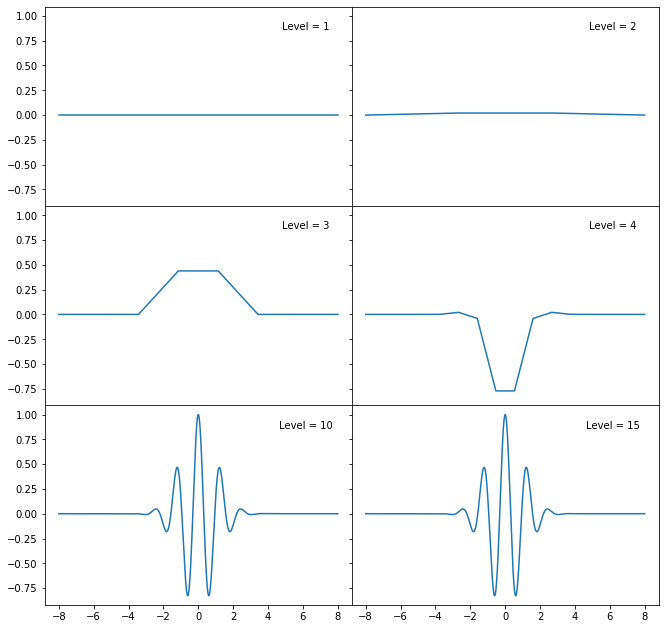

In [0]:
from pywt import ContinuousWavelet
    
plot_wavelet(ContinuousWavelet('morl'))

In [0]:
from pywt import scale2frequency, cwt

def cwt_wavelet_decompose(data, freq, waveletname, output=False):
    
    scales = np.arange(0.25, (freq/20)+0.25, 0.1)
    frequencies = scale2frequency(waveletname, scales) / (freq*0.0001)  # 100 Hz sampling is 0.01
    
    # transpose the data
    data_t = data.transpose()
    
    # get the wavelet coefficients at each level in a list
    coeffs_list = cwt(data_t.values, scales, waveletname)

    decom_wavelets = pd.DataFrame(coeffs_list[0][:,0,:], index =np.round(frequencies, 2)).T
    
    if output:
        display(decom_wavelets.head())
    
    return decom_wavelets

print(color.BOLD+color.UNDERLINE+'Baseline Wavelets'+color.END)
baseline_wavelets = cwt_wavelet_decompose(baseline_df, sample_rate, 'morl', output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Wavelets'+color.END)
seizure_wavelets = cwt_wavelet_decompose(seizure_df, sample_rate, 'morl',  output=True)

Baseline Wavelets


,187.20,133.72,104.00,85.09,72.00,62.40,55.06,49.26,44.57,40.70,37.44,34.67,32.28,30.19,28.36,26.74,25.30,24.00,22.83,21.77,20.80,19.92,19.10,18.35,17.66,17.02,16.42,15.86,15.34,14.86,14.40,13.97,13.57,13.18,12.82,12.48,12.16,11.85,11.56,11.28,...,9.45,9.27,9.09,8.91,8.75,8.59,8.43,8.28,8.14,8.00,7.87,7.74,7.61,7.49,7.37,7.26,7.15,7.04,6.93,6.83,6.73,6.64,6.55,6.46,6.37,6.28,6.20,6.12,6.04,5.96,5.89,5.81,5.74,5.67,5.60,5.54,5.47,5.41,5.35,5.29
0,-0.000411,-1.388264,0.900864,-5.492025,25.940260,-0.011700,-19.519390,3.660814,31.258643,26.202985,0.111262,9.838610,34.837459,38.020392,24.406023,0.249975,35.056904,43.860629,36.304565,20.689052,-0.573420,48.954403,47.901940,36.460115,20.340266,0.498699,52.068470,45.501748,31.416463,16.381493,-0.925586,49.413403,40.810282,26.886768,14.392554,-4.490241,46.298696,36.986136,21.246328,6.675910,...,32.030826,15.950710,-1.889764,-14.485742,48.269654,32.277839,20.384335,1.587223,-11.698444,53.163815,35.929934,22.441668,8.300707,-5.830092,59.823503,45.858336,32.676272,17.700641,2.844810,64.329538,56.899218,41.587352,26.848899,11.285877,69.734512,56.733495,41.444285,32.998053,17.417952,73.256108,60.045415,42.667464,34.814269,18.711751,65.092428,57.463197,43.260279,26.236975,16.511702,61.228663
1,0.001944,-0.018053,-0.016705,-0.315429,2.841821,0.961155,-1.918896,7.633216,1.944771,-18.689644,-16.444053,0.387231,-18.365274,-26.198696,-10.572397,12.796810,-26.206228,-21.139462,-4.498348,18.936393,40.153784,-19.597186,-0.574068,22.198707,40.005292,50.485898,3.933991,21.579286,39.623447,49.927568,53.507647,27.514688,40.187166,51.328061,55.297388,53.530347,44.380116,53.963761,58.708860,57.822986,...,75.385281,72.814024,67.266573,56.619805,87.619448,86.319883,82.151414,75.286238,64.436156,100.216016,95.518072,91.644687,79.993410,70.294001,109.721622,104.718416,99.694671,90.863341,76.218092,113.860760,109.660273,102.512004,94.312328,83.269599,113.816281,108.811096,102.373285,91.786473,79.377364,109.058193,103.799524,94.304628,83.747942,77.429754,100.684210,94.685804,84.635611,80.077824,68.092448,94.413625
2,0.000258,0.377326,-0.823516,-0.687931,-0.247836,0.244110,2.056860,2.701147,-1.024520,1.540807,8.983704,-0.265980,7.754523,13.223934,3.617067,-14.605457,8.800053,-0.264838,-15.810376,-29.348344,-30.613083,-16.662704,-30.038807,-35.731955,-30.593689,-15.424214,-31.309734,-31.655256,-23.512543,-10.738679,9.852650,-26.618519,-15.687645,-0.892953,13.224655,31.918220,-6.744138,7.405315,23.464166,38.622981,...,56.468016,71.766490,80.223263,85.535725,69.147262,78.102307,88.505302,95.765678,100.304460,84.591752,96.836650,104.918298,108.906361,110.432101,98.848704,106.023242,113.996455,116.408359,117.139692,104.126929,110.863174,114.562630,117.188264,117.229108,103.609263,109.203606,111.532967,112.632149,111.319531,100.393167,105.150167,105.955568,106.159073,104.037695,98.326729,101.294916,102.465879,100.426007,99.091457,98.366132
3,0.000456,0.643251,-1.269475,-0.648016,-1.922901,0.142530,4.925125,4.070827,1.199066,0.850847,-0.629662,-4.389466,-6.448705,-8.469204,-3.974303,4.835567,0.941166,4.597574,10.220275,9.180553,-0.932622,20.516909,17.995770,7.466411,-7.693110,-22.351608,6.252912,-5.562799,-19.972934,-29.035510,-31.163051,-16.197641,-26.290603,-30.377469,-28.682358,-20.000120,-29.032212,-28.552306,-23.110590,-11.490197,...,4.603851,19.381106,34.844635,49.818742,7.466126,24.299020,41.636034,58.705006,74.993771,20.162930,37.902664,57.305234,73.848008,85.616393,36.026412,49.594520,68.907783,80.558844,94.603408,44.644554,58.249294,71.364655,83.624672,96.681006,46.640175,60.774390,74.548214,84.465504,93.275894,53.403694,65.973706,76.832816,86.054131,94.222206,61.974296,73.712779,82.050677,87.946832,94.603891,73.931426
4,0.000541,1.643018,-3.400146,-2.330999,-3.655192,0.168342,8.410987,5.486967,-0.877743,-2.913698,-3.824550,7.863544,10.290354,10.636702,7.504214,2.171099,1.260060,3.090508,4.751138,9.028781,16.049879,-9.129263,0.001085,10.033402,15.932539,15.207500,8.288113,13.652470,12.275845,4.504212,-5.31358


Seizure Wavelets


,187.20,133.72,104.00,85.09,72.00,62.40,55.06,49.26,44.57,40.70,37.44,34.67,32.28,30.19,28.36,26.74,25.30,24.00,22.83,21.77,20.80,19.92,19.10,18.35,17.66,17.02,16.42,15.86,15.34,14.86,14.40,13.97,13.57,13.18,12.82,12.48,12.16,11.85,11.56,11.28,...,9.45,9.27,9.09,8.91,8.75,8.59,8.43,8.28,8.14,8.00,7.87,7.74,7.61,7.49,7.37,7.26,7.15,7.04,6.93,6.83,6.73,6.64,6.55,6.46,6.37,6.28,6.20,6.12,6.04,5.96,5.89,5.81,5.74,5.67,5.60,5.54,5.47,5.41,5.35,5.29
0,0.000222,-0.464607,-1.829348,-9.873300,33.663515,0.243542,-18.756779,12.629741,45.986627,36.042725,-1.563692,13.752279,49.873396,54.176164,34.722945,0.014399,52.719333,65.113389,54.836747,32.406708,2.238181,72.302588,72.119019,57.356394,34.941918,5.769138,81.854811,75.357564,56.167885,34.750145,10.470061,85.704947,75.204391,57.657812,40.161375,14.032710,87.310324,77.703679,58.095597,39.345959,...,75.098753,57.610138,35.671822,19.495519,83.581034,68.022657,55.815802,33.141645,18.188960,89.176404,70.523098,57.975569,42.996601,26.618160,111.528750,100.524133,88.711988,73.601390,56.349601,145.314507,143.259201,129.455504,115.520927,98.265947,179.279838,168.303679,155.348994,150.442022,133.014759,192.378074,182.618639,169.234967,165.841492,149.660596,167.804792,167.928158,154.919085,143.045871,138.083245,123.526852
1,0.003291,1.640008,-3.182929,-1.707251,-3.041071,1.497540,8.009557,15.535760,-1.846343,-31.452905,-25.331466,3.118027,-24.421894,-35.680773,-13.514772,20.107538,-40.067204,-32.554933,-7.273139,27.170829,59.069270,-30.490686,-2.324584,32.564024,59.961916,77.679207,4.439106,32.820005,62.144939,79.674193,87.984542,37.497111,59.634213,81.031648,90.782148,93.964156,61.131476,80.075083,93.908885,98.708428,...,94.534012,99.506685,98.045713,90.045494,97.562594,105.267731,105.536533,105.122050,97.275948,129.161361,130.858087,132.137882,125.539925,119.133629,166.671660,169.495666,170.983215,167.958383,154.080744,198.357814,200.071545,199.173199,196.728226,188.971497,203.842583,205.889475,205.075030,200.949853,194.566915,176.487483,181.304468,177.880184,175.763244,176.433914,122.798918,125.042033,123.405593,128.567397,122.911814,50.089453
2,0.000036,0.973350,-1.647513,0.046533,-6.793767,0.127073,8.039856,1.625659,-8.469543,0.394436,15.317181,-3.875946,5.971393,14.223914,0.590060,-24.175595,15.311804,-0.074157,-23.180984,-43.708407,-46.335997,-22.403349,-43.094848,-52.800783,-46.320487,-24.219623,-54.814881,-54.975111,-42.914806,-23.383708,8.304972,-53.869308,-38.812280,-15.557984,7.106626,38.056690,-35.150735,-14.862413,10.374670,35.753755,...,31.320285,57.167682,75.161974,88.855990,54.719453,71.970507,90.808743,108.323259,121.738074,103.240626,121.931845,139.789117,151.858377,160.559913,143.437971,157.952359,175.466127,185.611218,192.917002,152.021006,164.844899,178.824471,191.377386,197.123999,125.723112,140.808454,153.238085,162.744827,172.038583,69.346235,89.102401,96.220985,109.804652,115.224020,0.706649,15.703356,26.912042,35.460436,45.820768,-69.242958
3,-0.000151,0.600457,-1.069140,-0.158932,-3.736059,-0.159457,4.809462,0.191601,-2.072914,1.833676,-1.336032,0.526643,-0.647685,-3.203210,1.345081,12.358007,-0.884891,8.041300,18.074356,17.203748,1.389789,21.802909,19.245286,3.766283,-18.852220,-40.342167,5.821337,-14.189934,-37.176635,-52.764829,-59.824957,-32.326903,-50.816853,-62.032112,-62.702828,-53.770003,-66.172809,-71.326952,-68.367237,-55.428207,...,-30.218022,-15.075857,5.211000,26.375515,-2.679116,18.373403,38.524329,61.584893,85.845841,32.834016,53.467498,77.821515,102.916877,120.694288,45.089638,62.283519,90.994990,110.685761,134.509411,21.112325,38.479815,61.995144,86.033484,106.335541,-33.883975,-10.123852,11.085821,33.563785,55.181778,-94.700214,-68.043381,-54.409940,-30.322005,-11.823672,-153.129740,-131.137927,-113.788982,-101.561543,-84.450294,-193.124398
4,-0.000073,0.363402,-0.634177,-0.055088,-2.379362,-0.100152,2.795479,-0.047174,-1.537258,-0.479863,-0.654040,0.678273,0.355805,0.811219,-0.373564,-2.831705,-1.197686,-3.877256,-3.945139,2.513922,13.368942,-3.147071

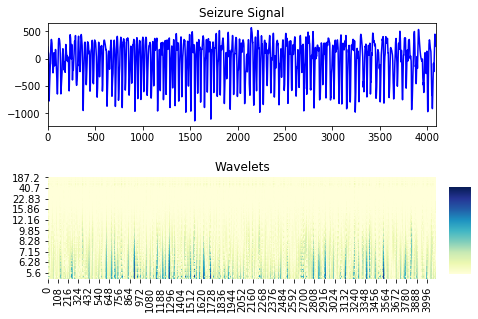

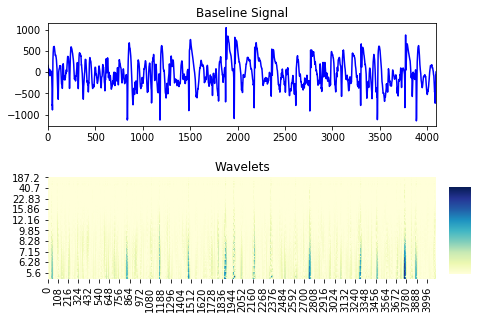

In [0]:
def plot_cwt_scalogram(signal, wt_data, interpolation, class_name):
  
  cmap = plt.cm.cool
  x = range(len(signal))
  
  # Show signal and wavelet packet coefficients
  fig, (sig_ax, spec_ax) = plt.subplots(2)
  fig.subplots_adjust(hspace=0.5, bottom=.03, left=.07, right=.97, top=.92)
  
  # plot the signal
  sig_ax.set_title(class_name + " Signal")
  sig_ax.plot(x, signal, 'b')
  sig_ax.set_xlim(0, x[-1])
  
  # plot the spectrogram
  cbar_ax = fig.add_axes([1, 0.05, 0.05, 0.3])
  spec_ax.set_title("Wavelets")
  sns.heatmap(wt_data.T.abs(), ax=spec_ax, cmap="YlGnBu", cbar_ax=cbar_ax, 
              cbar_kws={"ticks":[]}
              )
  
  plt.show()

plot_cwt_scalogram(seizure_df, 
               seizure_wavelets, 
               None, 'Seizure')

plot_cwt_scalogram(baseline_df, 
               baseline_wavelets, 
               None, 'Baseline')

### Undecimated (Stationary) Wavelet Transform

Unlike DWT, where an odd or even decimation can be made, UDWT uses both odd and even transformations at each scale. UDWT is a more computationally intensive method than DWT, but can result in better discrimination between noise and activity, as well as more precise frequency localization. 

**NOTE**
- I tend to use these over DWT these days for the reasons above.
- the way the data is output from the swt is the same as DWT if you set ``trim_approx =True``
- the method is algorithm a-trous meaning the data needs to be a multiple of 2**level on the axis to be transformed. EEG data is normally recorded in such lengths so this works nicely (e.g. 512, 256). However if you are applying this to a long set of data, you will need to pad it first and then remove the padding after.

In [0]:
from pywt import swt

def swt_wavelet_decompose(data, freq, waveletname, output=False):
      
    # decompose data into coefficients
    level = 6

    # return the frequencies
    frequencies = np.array([seiz_freq]*level)
    j = [1<<exponent for exponent in range(level)]
    frequencies = frequencies/j

    # transpose the data
    data_t = data.transpose()
    
    # get the wavelet coefficients at each level in a list
    coeffs_list = swt(data.T, waveletname, level=level, trim_approx =True)

    # make a list of the component names (later column rows)
    nums = list(range(1,level+1))
    names=[]
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[-1]))
    
    # reverse the names so it counts down
    names = names[::-1] 
    
    # make an empy dataframe
    wavelets = pd.DataFrame()
    
    # for each array in the list of arrays
    for i, array in enumerate(coeffs_list):
        # turn into a dataframe and transpose
        level_df = pd.DataFrame(array).T
        # name the column the appropriate level name
        level_df.columns = [names[i]]
        # if the wavelets df is empty...
        if wavelets.empty:
            # ... make the first level df the wavelets df
            wavelets = level_df
        # ..otherwise...
        else:
            # ... add the next levels df to another column
            wavelets = pd.concat([wavelets,level_df], axis=1)
    
    # remove the AN levels
    regex = re.compile('D')
    bad_items = [x for x in list(wavelets.columns) if not regex.match(x)]
    decom_wavelets = wavelets.drop(bad_items, axis=1)
    
    if output:
        display(decom_wavelets.head())
    
    return decom_wavelets, frequencies

print(color.BOLD+color.UNDERLINE+'Baseline Wavelets'+color.END)
baseline_wavelets, frequencies = swt_wavelet_decompose(baseline_df.iloc[:-1], sample_rate, 'db4', output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Wavelets'+color.END)
seizure_wavelets, frequencies  = swt_wavelet_decompose(seizure_df.iloc[:-1], sample_rate, 'db4',  output=True)

Baseline Wavelets


,D6,D5,D4,D3,D2,D1
0,-1273.602570,-105.529467,-411.084913,-76.666336,-58.264662,2.594395
1,-1245.339372,-57.151614,-428.615430,-53.684694,-45.140779,10.195646
2,-1200.475794,-4.130656,-433.927375,-21.693524,-19.696615,-15.448868
3,-1138.352183,47.441005,-430.417979,-7.945208,9.743360,18.439460
4,-1059.187438,94.817604,-421.560644,-10.516593,33.707564,-11.257192



Seizure Wavelets


,D6,D5,D4,D3,D2,D1
0,77.459769,-2201.499253,-158.072735,81.904482,17.369233,-1.235788
1,141.464637,-1944.860140,-387.971624,239.564932,10.694653,2.744152
2,200.560585,-1655.287038,-602.283827,393.998362,10.990782,-0.680125
3,254.623250,-1337.305708,-766.077301,456.899861,8.377455,1.448993
4,303.105157,-995.118352,-851.053985,351.999336,3.005205,-0.702219


**NOTE**
- this is pretty much the same  as CWT plotting except you switch axis around

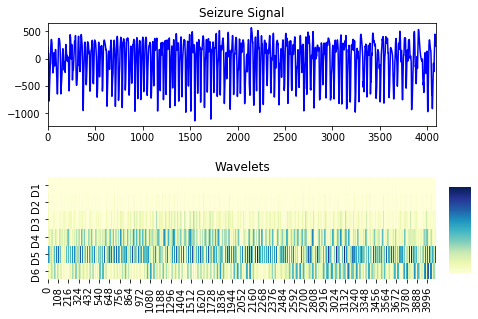

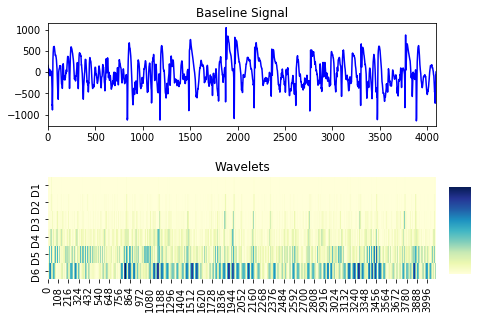

In [0]:
def plot_cwt_scalogram(signal, wt_data, interpolation, class_name):
  
  cmap = plt.cm.cool
  x = range(len(signal))
  
  # Show signal and wavelet packet coefficients
  fig, (sig_ax, spec_ax) = plt.subplots(2)
  fig.subplots_adjust(hspace=0.5, bottom=.03, left=.07, right=.97, top=.92)
  
  # plot the signal
  sig_ax.set_title(class_name + " Signal")
  sig_ax.plot(x, signal, 'b')
  sig_ax.set_xlim(0, x[-1])
  
  # plot the spectrogram
  cbar_ax = fig.add_axes([1, 0.05, 0.05, 0.3])
  spec_ax.set_title("Wavelets")
  sns.heatmap(wt_data.T.abs(), ax=spec_ax, cmap="YlGnBu", cbar_ax=cbar_ax, 
              cbar_kws={"ticks":[]}
              )
  
  spec_ax.invert_yaxis()
  plt.show()

plot_cwt_scalogram(seizure_df, 
               seizure_wavelets, 
               None, 'Seizure')

plot_cwt_scalogram(baseline_df, 
               baseline_wavelets, 
               None, 'Baseline')

### Wavelet Packets

**TODO**
- convert from the OLD Convolutional Neural Networks tutorials

## Entropy

Entropy can be used as a measure of the randomness, information, and compressibility of a system; with the more "*random*" or unstructured a variable, the larger the entropy value. 

Entropy quantifies the amount of disorder in a system, with more disorder indicating more information is transferred in a single measurement and therefore less efficiency in communicating this information. During the calculation of entropy, the signal can be coarsely or finely divided up into larger or smaller bins.

As entropy measures the complexity or irregularity of biomedical signals, it can be applied to seizure detection as brain activity during a seizure is more predictable than normally, and can therefore be reflected reduction in the entropy value<sup>1-4</sup>.

A really easy package I found to apply entropy to a signal is EntroPy which we will use here.

---
1. Yuan2012
2. Omerhodzic2013
3. Paivinen2005
4. Hamdan2015

In [0]:
!git clone https://github.com/raphaelvallat/entropy.git entropy/

Cloning into 'entropy'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 1119 (delta 56), reused 69 (delta 35), pack-reused 1011
Receiving objects: 100% (1119/1119), 2.02 MiB | 23.00 MiB/s, done.
Resolving deltas: 100% (671/671), done.


In [0]:
from entropy.entropy import sample_entropy
baseline_sam = np.apply_along_axis(sample_entropy, 0, baseline_df)
seizure_sam = np.apply_along_axis(sample_entropy, 0, seizure_df)

print(color.BOLD+color.UNDERLINE+"Baseline"+color.END)
display(baseline_sam)
print(color.BOLD+color.UNDERLINE+"Seizure"+color.END)
display(seizure_sam)

Baseline


array([0.39452082])

Seizure


array([0.43048457])

From the package code spectral entropy is...

"*...defined to be the Shannon entropy of the power spectral density (PSD) of the data*"

Shannon entropy is commonly used for normalised EEG, which partitions the phase space into a number of bins and calculates the probability by counting the number of data points in each bin<sup>1,2,3</sup>.

---
1. Varsavsky2011
2. Kiranyaz2014
3. Iesmantas2019

In [0]:
from entropy.entropy import spectral_entropy

baseline_spec = np.apply_along_axis(spectral_entropy, 0, baseline_df, sample_rate,
                                method='welch', nperseg = sample_rate)

seizure_spec = np.apply_along_axis(spectral_entropy, 0, seizure_df, sample_rate,
                                method='welch', nperseg = sample_rate)

print(color.BOLD+color.UNDERLINE+"Baseline"+color.END)
display(baseline_spec)
print(color.BOLD+color.UNDERLINE+"Seizure"+color.END)
display(seizure_spec)

Baseline


array([3.13093832])

Seizure


array([3.36958247])

## Correlation and Eigenvalues

This method relies on having multiple channels, so we can't use it on the Epileptologie Dataset. 

When the Kaggle competition (described in the last notebook) was running, the top 3 scorers used correlations between channels in some way. The following code is closely based on the winning submission by Michael Hills<sup>1</sup>.

His work was primarily inspired by Schindler, Leung, Elger & Lehnertz (2007)<sup>2</sup>, who showed that correlation coefficients in the time domain and corresponding eigenvalues are effective features. Hill used this as well as the correlation coefficients between EEG channels and their eigenvalues in the frequency domain. 

The first step therefore is to apply a Fast Fourier Transform to each 1 second clip across all EEG channels. The log10 of the frequency magnitudes is taken, discarding phase information. 1-47Hz was the chosen frequency range as 0Hz could be instrument noise, and the upper frequency was chosen through trial and error. The FFT output is normalised across frequency and the correlation coefficients matrix calculated. Eigenvalues are calculated on the correlation matrix with complex eigenvalues made real by taking the complex magnitude. The first two features are then the eigenvalues and the upper right triangle of the correlation coefficients (as the matrix is symmetric so has repeated information). The other 2 features extracted have a similar process but, instead of being in the frequency domain, they are in the time domain after being resampled down to 400Hz.

Lets walk through this step by step. First we get the fourier transform.

**Note**
- My version is altered from the original and is slower as it uses Pandas instead of numpy. However hopefully this makes it easier to follow.

---
1. https://github.com/MichaelHills/seizure-detection
2. K Schindler, H Leung, CE Elger, K Lehnertz (2007) Assessing seizure dynamics by analysing the correlation structure of multichannel intracranial EEG. Brain 130(Pt1):65-77

In [0]:
def fft(time_data):
  return np.log10(np.absolute(np.fft.rfft(time_data, axis=1)[:,1:48]))

example_fft = pd.DataFrame(fft(seiz_df.T), 
                           index = seiz_df.columns
                          )
example_fft.columns.name = 'freq'
example_fft.head()

freq,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
channel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
EEG FP1-REF,5.889447,5.895735,5.866488,5.901126,5.923684,5.849559,5.875947,5.857437,6.008794,5.755965,6.015106,5.964912,5.923368,5.818875,5.880921,6.053352,6.018840,5.973494,5.977266,5.906040,6.131972,6.128231,6.050937,6.271422,6.117634,6.127443,6.222288,5.976853,6.231172,6.210359,5.872649,6.192003,6.221915,5.848642,6.150489,6.005455,6.254382,6.362460,6.135519,6.291165,6.410140,6.204739,6.250192,6.325462,6.230742,6.401350,6.294194
EEG FP2-REF,5.892734,5.888589,5.859617,5.892270,5.926124,5.838700,5.865274,5.844193,6.028302,5.778333,5.983281,5.941957,5.878744,5.805196,5.897476,6.020150,6.018271,5.904534,6.001818,5.885020,6.041500,6.107261,6.029910,6.271491,6.146093,6.127100,6.226423,5.997122,6.309696,6.206915,5.850764,6.212632,6.225463,5.968784,6.168946,5.985955,6.274325,6.381119,6.176198,6.281585,6.399143,6.137743,6.233678,6.324403,6.155271,6.399256,6.244533
EEG F3-REF,5.882234,5.878518,5.847965,5.873239,5.909531,5.821951,5.864111,5.846224,5.982744,5.808581,5.945433,5.939057,5.919505,5.826858,5.890558,6.054443,5.935291,5.995135,5.839088,5.797129,6.163419,6.149034,5.928915,6.209218,6.059988,6.077599,6.218509,5.947601,6.166924,6.137799,6.075300,6.176730,6.227604,5.959323,6.144436,6.122650,6.151121,6.268361,6.042711,6.202702,6.290950,6.211526,6.213592,6.279729,6.177071,6.222068,6.268861
EEG F4-REF,5.850455,5.849846,5.820742,5.859587,5.870478,5.795654,5.832265,5.853410,5.987226,5.814884,5.890271,5.896510,5.899227,5.821206,5.896330,6.029441,5.932666,5.964134,5.926744,5.835626,6.091963,6.094201,5.886090,6.247418,6.016780,6.055591,6.208889,6.023572,6.201260,6.125613,6.075539,6.124663,6.223880,6.074031,6.164781,6.158495,6.155972,6.286130,6.122256,6.226185,6.238861,6.136975,6.196480,6.338601,6.146838,6.256747,6.198106
EEG C3-REF,5.942554,5.971279,5.941573,5.956500,5.963069,5.884175,5.915267,5.955694,6.009665,5.857037,5.995300,5.960889,5.966188,5.923428,5.944957,6.079770,5.987291,6.045554,5.993031,5.874140,6.147926,6.154499,5.951492,6.255184,5.969900,6.080676,6.227335,6.061080,6.183387,6.130291,6.119755,6.155253,6.244745,6.036962,6.152030,6.173439,6.168687,6.242660,6.064519,6.212639,6.230528,6.164386,6.161266,6.311893,6.189654,6.242569,6.168268


Now we scale the data across each frequency.

In [0]:
from sklearn import preprocessing
example_scaled = pd.DataFrame(preprocessing.scale(example_fft, axis=0), 
                              index = example_fft.index, 
                              columns = example_fft.columns)
example_scaled.head()

freq,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
channel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
EEG FP1-REF,0.173858,0.151490,0.119408,0.284697,0.295398,0.243342,0.093519,-0.837654,0.411009,-1.284059,0.831885,0.317591,-0.017562,-0.605783,-0.814668,-0.072373,1.301648,-0.506819,0.291562,0.585177,-0.079596,0.160804,1.936497,0.829924,1.377698,1.553828,0.389100,-1.532095,0.776474,1.800516,-2.420926,0.819240,0.000667,-1.919796,0.241018,-2.044597,1.389918,1.294879,0.007219,1.399263,2.425016,0.459848,1.108001,-0.138229,0.334148,1.363654,1.110580
EEG FP2-REF,0.228699,0.036543,0.016144,0.151109,0.337290,0.086232,-0.091128,-1.059013,0.721679,-0.902507,0.489876,-0.071838,-0.836898,-0.790596,-0.491193,-0.568953,1.290835,-1.471177,0.625909,0.226233,-1.673444,-0.162945,1.569247,0.832367,1.724618,1.546312,0.454224,-1.140588,2.072512,1.736402,-2.672098,1.103289,0.039215,-0.840333,0.412132,-2.384163,1.718563,1.469139,0.492284,1.179411,2.288670,-0.566261,0.866026,-0.158452,-0.340700,1.340118,0.711585
EEG F3-REF,0.053544,-0.125442,-0.158971,-0.135960,0.052350,-0.156092,-0.111245,-1.025076,-0.003860,-0.386546,0.083120,-0.121048,-0.088490,-0.497924,-0.626359,-0.056061,-0.286973,-0.204177,-1.590095,-1.274646,0.474394,0.481984,-0.194609,-1.382413,0.674979,0.460891,0.329564,-2.097109,-0.283958,0.449807,-0.095043,0.608927,0.062479,-0.925339,0.184897,-0.003816,-0.311777,0.416099,-1.099447,-0.630856,0.947286,0.563799,0.571720,-1.012013,-0.145773,-0.651293,0.907041
EEG F4-REF,-0.476536,-0.586600,-0.568079,-0.341883,-0.618317,-0.536556,-0.662182,-0.904962,0.067516,-0.279022,-0.509691,-0.842847,-0.460820,-0.574289,-0.513597,-0.429991,-0.336872,-0.637716,-0.396420,-0.617253,-0.784443,-0.364569,-0.942556,-0.023794,0.148256,-0.021676,0.178036,-0.629684,0.282770,0.222968,-0.092297,-0.108009,0.022014,0.105292,0.373520,0.620376,-0.231839,0.582043,-0.150930,-0.091957,0.301481,-0.578025,0.320975,0.112819,-0.416113,-0.261531,0.338574
EEG C3-REF,1.059699,1.366562,1.247797,1.119975,0.971746,0.744161,0.773761,0.804673,0.424873,0.440007,0.619033,0.249345,0.768631,0.806782,0.436523,0.322738,0.701773,0.500897,0.506245,0.040425,0.201454,0.566349,0.199691,0.252418,-0.423225,0.528377,0.468598,0.094798,-0.012230,0.310054,0.415181,0.313201,0.248731,-0.227760,0.255302,0.880610,-0.022296,0.176085,-0.839399,-0.402798,0.198163,-0.158196,-0.194996,-0.397470,-0.033255,-0.420882,0.098853


Then we get the correlation coefficients from a Pearson product-moment.

In [0]:
example_corr_matrix = pd.DataFrame(np.corrcoef(example_scaled), 
                                   index = example_scaled.index, 
                                   columns = example_scaled.index)

example_corr_matrix.head()

channel,EEG FP1-REF,EEG FP2-REF,EEG F3-REF,EEG F4-REF,EEG C3-REF,EEG C4-REF,EEG P3-REF,EEG P4-REF,EEG O1-REF,EEG O2-REF,EEG F7-REF,EEG F8-REF,EEG T3-REF,EEG T4-REF,EEG T5-REF,EEG T6-REF,EEG A1-REF,EEG A2-REF,EEG FZ-REF,EEG CZ-REF,EEG PZ-REF,EEG T1-REF,EEG T2-REF
channel,,,,,,,,,,,,,,,,,,,,,,,
EEG FP1-REF,1.000000,0.900769,0.397836,0.155415,-0.218850,-0.239897,-0.201665,-0.100269,-0.106379,-0.149652,0.178193,-0.023285,-0.365331,-0.105881,-0.554501,-0.225780,-0.145329,-0.103967,-0.040530,-0.351370,-0.057004,0.032821,-0.512753
EEG FP2-REF,0.900769,1.000000,0.232462,0.319116,-0.277190,-0.241915,-0.148667,-0.050647,0.008091,-0.057006,-0.001486,0.223775,-0.438867,0.035107,-0.510967,-0.201035,-0.248279,-0.146708,-0.074316,-0.318914,-0.010032,-0.165759,-0.251854
EEG F3-REF,0.397836,0.232462,1.000000,0.322304,0.126895,-0.142741,-0.034056,0.077502,-0.572451,0.102138,0.388052,-0.098056,0.225257,-0.041897,-0.106234,-0.083389,-0.260139,-0.384316,0.148419,0.106147,0.299402,0.320307,-0.306137
EEG F4-REF,0.155415,0.319116,0.322304,1.000000,-0.331378,-0.527114,0.620191,0.280537,-0.305371,0.515111,-0.467418,0.768639,-0.192459,0.557322,0.181337,-0.117732,-0.455733,-0.189961,-0.297141,-0.006726,0.670644,-0.304184,0.517098
EEG C3-REF,-0.218850,-0.277190,0.126895,-0.331378,1.000000,0.744662,-0.451207,-0.292237,-0.055574,-0.528370,0.688476,-0.475349,0.714537,-0.544482,0.209203,-0.240433,-0.291729,-0.185993,0.779092,0.725923,-0.280954,0.374169,-0.266106


We get the eigenvalues and only take the first array out. We get the absolute to make them 'real' and then sort them by value.

**TODO**
- explain what eigenvalues are

In [0]:
eigenvalues = np.linalg.eig(example_corr_matrix)[0]
eigenvalues = np.absolute(eigenvalues)
example_eigenvalues = pd.DataFrame(eigenvalues, index=example_corr_matrix.index+'|freq_eigen')
example_eigenvalues = example_eigenvalues.sort_values(0)
example_eigenvalues.head()

,0
channel,
EEG T5-REF|freq_eigen,1.331901e-16
EEG A1-REF|freq_eigen,1.518899e-02
EEG A2-REF|freq_eigen,1.658034e-02
EEG FZ-REF|freq_eigen,2.437626e-02
EEG CZ-REF|freq_eigen,3.147567e-02


For the second feature we get the upper right of the triangle. We can do this, while preserving names, by first turning the bottom left to nan...

In [0]:
example_corr_nan = example_corr_matrix.where(np.triu(np.ones(example_corr_matrix.shape)).astype(np.bool))
example_corr_nan.head()

channel,EEG FP1-REF,EEG FP2-REF,EEG F3-REF,EEG F4-REF,EEG C3-REF,EEG C4-REF,EEG P3-REF,EEG P4-REF,EEG O1-REF,EEG O2-REF,EEG F7-REF,EEG F8-REF,EEG T3-REF,EEG T4-REF,EEG T5-REF,EEG T6-REF,EEG A1-REF,EEG A2-REF,EEG FZ-REF,EEG CZ-REF,EEG PZ-REF,EEG T1-REF,EEG T2-REF
channel,,,,,,,,,,,,,,,,,,,,,,,
EEG FP1-REF,1.0,0.900769,0.397836,0.155415,-0.218850,-0.239897,-0.201665,-0.100269,-0.106379,-0.149652,0.178193,-0.023285,-0.365331,-0.105881,-0.554501,-0.225780,-0.145329,-0.103967,-0.040530,-0.351370,-0.057004,0.032821,-0.512753
EEG FP2-REF,NaN,1.000000,0.232462,0.319116,-0.277190,-0.241915,-0.148667,-0.050647,0.008091,-0.057006,-0.001486,0.223775,-0.438867,0.035107,-0.510967,-0.201035,-0.248279,-0.146708,-0.074316,-0.318914,-0.010032,-0.165759,-0.251854
EEG F3-REF,NaN,NaN,1.000000,0.322304,0.126895,-0.142741,-0.034056,0.077502,-0.572451,0.102138,0.388052,-0.098056,0.225257,-0.041897,-0.106234,-0.083389,-0.260139,-0.384316,0.148419,0.106147,0.299402,0.320307,-0.306137
EEG F4-REF,NaN,NaN,NaN,1.000000,-0.331378,-0.527114,0.620191,0.280537,-0.305371,0.515111,-0.467418,0.768639,-0.192459,0.557322,0.181337,-0.117732,-0.455733,-0.189961,-0.297141,-0.006726,0.670644,-0.304184,0.517098
EEG C3-REF,NaN,NaN,NaN,NaN,1.000000,0.744662,-0.451207,-0.292237,-0.055574,-0.528370,0.688476,-0.475349,0.714537,-0.544482,0.209203,-0.240433,-0.291729,-0.185993,0.779092,0.725923,-0.280954,0.374169,-0.266106


...and now just stack to remove the unwanted nans

In [0]:
example_corr_stacked = example_corr_nan.stack()
# combine the multi_index to 1 index name
example_corr_stacked.index = ['_'.join(map(str,i)) for i in example_corr_stacked.index.tolist()]
# add the corr to the name
example_corr_stacked.index = example_corr_stacked.index+'|freq_corr'
example_corr_stacked.head()

EEG FP1-REF_EEG FP1-REF|freq_corr    1.000000
EEG FP1-REF_EEG FP2-REF|freq_corr    0.900769
EEG FP1-REF_EEG F3-REF|freq_corr     0.397836
EEG FP1-REF_EEG F4-REF|freq_corr     0.155415
EEG FP1-REF_EEG C3-REF|freq_corr    -0.218850
dtype: float64

Lets now make this a function. 

**NOTE**
- A similar approach is taken to get them in the time domain.

In [0]:
import scipy
import sklearn

def eigen_corr(data, name):
  scaled = pd.DataFrame(preprocessing.scale(data, axis=0),
                        index = data.index, 
                        columns = data.columns)
  corr_matrix = pd.DataFrame(np.corrcoef(scaled),
                             index = scaled.index,
                             columns = scaled.index)
  eigenvalues = pd.DataFrame(np.absolute(np.linalg.eig(corr_matrix)[0]),
                             index=corr_matrix.index+'|'+name+'_eigen')
  #eigenvalues = eigenvalues.sort_values(0)

  corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape)).astype(np.bool)).stack()
  corr.index = ['_'.join(map(str,i)) for i in corr.index.tolist()]
  # add the corr to the name
  corr.index = corr.index+'|'+name+'_corr'

  return eigenvalues, corr

def hills(data):
  fft_data = pd.DataFrame(fft(data.T),
                          index = data.columns)

  fft_eigenvalues, fft_corr = eigen_corr(fft_data, 'freq')

  resampled = scipy.signal.resample(data.T, 400, axis=1) \
  if data.T.shape[-1] > 400 else data.T

  resampled = pd.DataFrame(resampled, index = data.columns)

  time_eigenvalues, time_corr = eigen_corr(resampled, 'time')

  combined = pd.concat([fft_eigenvalues, fft_corr, time_eigenvalues, time_corr]).T

  return combined
    
example_hills = hills(seiz_df)
example_hills.head()

,EEG FP1-REF|freq_eigen,EEG FP2-REF|freq_eigen,EEG F3-REF|freq_eigen,EEG F4-REF|freq_eigen,EEG C3-REF|freq_eigen,EEG C4-REF|freq_eigen,EEG P3-REF|freq_eigen,EEG P4-REF|freq_eigen,EEG O1-REF|freq_eigen,EEG O2-REF|freq_eigen,EEG F7-REF|freq_eigen,EEG F8-REF|freq_eigen,EEG T3-REF|freq_eigen,EEG T4-REF|freq_eigen,EEG T5-REF|freq_eigen,EEG T6-REF|freq_eigen,EEG A1-REF|freq_eigen,EEG A2-REF|freq_eigen,EEG FZ-REF|freq_eigen,EEG CZ-REF|freq_eigen,EEG PZ-REF|freq_eigen,EEG T1-REF|freq_eigen,EEG T2-REF|freq_eigen,EEG FP1-REF_EEG FP1-REF|freq_corr,EEG FP1-REF_EEG FP2-REF|freq_corr,EEG FP1-REF_EEG F3-REF|freq_corr,EEG FP1-REF_EEG F4-REF|freq_corr,EEG FP1-REF_EEG C3-REF|freq_corr,EEG FP1-REF_EEG C4-REF|freq_corr,EEG FP1-REF_EEG P3-REF|freq_corr,EEG FP1-REF_EEG P4-REF|freq_corr,EEG FP1-REF_EEG O1-REF|freq_corr,EEG FP1-REF_EEG O2-REF|freq_corr,EEG FP1-REF_EEG F7-REF|freq_corr,EEG FP1-REF_EEG F8-REF|freq_corr,EEG FP1-REF_EEG T3-REF|freq_corr,EEG FP1-REF_EEG T4-REF|freq_corr,EEG FP1-REF_EEG T5-REF|freq_corr,EEG FP1-REF_EEG T6-REF|freq_corr,EEG FP1-REF_EEG A1-REF|freq_corr,...,EEG T5-REF_EEG CZ-REF|time_corr,EEG T5-REF_EEG PZ-REF|time_corr,EEG T5-REF_EEG T1-REF|time_corr,EEG T5-REF_EEG T2-REF|time_corr,EEG T6-REF_EEG T6-REF|time_corr,EEG T6-REF_EEG A1-REF|time_corr,EEG T6-REF_EEG A2-REF|time_corr,EEG T6-REF_EEG FZ-REF|time_corr,EEG T6-REF_EEG CZ-REF|time_corr,EEG T6-REF_EEG PZ-REF|time_corr,EEG T6-REF_EEG T1-REF|time_corr,EEG T6-REF_EEG T2-REF|time_corr,EEG A1-REF_EEG A1-REF|time_corr,EEG A1-REF_EEG A2-REF|time_corr,EEG A1-REF_EEG FZ-REF|time_corr,EEG A1-REF_EEG CZ-REF|time_corr,EEG A1-REF_EEG PZ-REF|time_corr,EEG A1-REF_EEG T1-REF|time_corr,EEG A1-REF_EEG T2-REF|time_corr,EEG A2-REF_EEG A2-REF|time_corr,EEG A2-REF_EEG FZ-REF|time_corr,EEG A2-REF_EEG CZ-REF|time_corr,EEG A2-REF_EEG PZ-REF|time_corr,EEG A2-REF_EEG T1-REF|time_corr,EEG A2-REF_EEG T2-REF|time_corr,EEG FZ-REF_EEG FZ-REF|time_corr,EEG FZ-REF_EEG CZ-REF|time_corr,EEG FZ-REF_EEG PZ-REF|time_corr,EEG FZ-REF_EEG T1-REF|time_corr,EEG FZ-REF_EEG T2-REF|time_corr,EEG CZ-REF_EEG CZ-REF|time_corr,EEG CZ-REF_EEG PZ-REF|time_corr,EEG CZ-REF_EEG T1-REF|time_corr,EEG CZ-REF_EEG T2-REF|time_corr,EEG PZ-REF_EEG PZ-REF|time_corr,EEG PZ-REF_EEG T1-REF|time_corr,EEG PZ-REF_EEG T2-REF|time_corr,EEG T1-REF_EEG T1-REF|time_corr,EEG T1-REF_EEG T2-REF|time_corr,EEG T2-REF_EEG T2-REF|time_corr
0,7.690189,3.809882,3.055029,2.565794,1.726729,1.136728,0.709747,0.642278,0.373889,0.308591,0.210114,0.203225,0.119681,0.099478,1.331901e-16,0.08385,0.015189,0.01658,0.024376,0.031476,0.045171,0.068932,0.063071,1.0,0.900769,0.397836,0.155415,-0.21885,-0.239897,-0.201665,-0.100269,-0.106379,-0.149652,0.178193,-0.023285,-0.365331,-0.105881,-0.554501,-0.22578,-0.145329,...,0.45229,0.500548,0.420009,0.119674,1.0,-0.142451,-0.089017,-0.321062,0.17453,0.402092,0.125216,0.261854,1.0,0.254821,-0.326527,-0.286375,-0.226144,-0.07343,-0.10205,1.0,-0.368227,-0.122799,-0.144573,-0.102464,0.156544,1.0,0.301103,-0.046626,-0.138434,-0.26765,1.0,0.763497,0.172491,0.149428,1.0,0.224436,0.161027,1.0,-0.452779,1.0


## Other Methods

There are two other documented models that came 2nd and 3rd in the competition which I wont go through in code but will outline<sup>1</sup>.

### ebenolson<sup>2</sup>

A combination of 1 to 4 log spaced butterworth filters was applied to the signal, between 1-200Hz.
The covariance matrix was then calculated to get the correlations between channels, with these normalised. The best combination of filters were evaluated on a subject by subject basis on its cross validated performance when classified using a logistic regression. A neural network classification was then used for classification.

### cdipsters<sup>3</sup>

**TODO**
- explain derivatives

24 individual channel features and 42 global features were used for each participant. The most basic averaged over all electrodes, resampling to 100Hz, then estimated the maximum, mean, and variance over 1 second. These maximum, mean, and variance features were then calculated on a channel by channel basis. These features were then calculated on the first and second derivatives of the time-series. Furthermore, a feature was also added for the mean of the covariance between all possible 2 channels. Classification was then done using an ExtraTreesClassifier.

---
1. https://github.com/sbaldassano/seizuredetection
2. https://github.com/ebenolson/seizure-detection
3. https://github.com/asood314/SeizureDetection

# Scaling

Scaling the features is important for most classifiers, except decision trees and random forests (we will talk about them in the next notebook). 

There are two general methods to scaling we will discuss; normalisation and standardization.

Normalisation converts signals into a common range so they can be compared, through detrending the signal by removing the mean or scaling to a unit variance to a range of 0-1 using methods such as min-max scaling. The mean of a single electrode recording depends on the amplifier gain, so normalisation is particularly required if comparing signals from different recording equipment or researchers.

Standardization is similar, but centres the feature columns at mean 0 with standard deviation 1 so that the features form a normal distribution. This is particularly useful for classifiers that use optimization algorithms, such as logistic regression and SVM, as it makes it easier for the model to learn weights and makes the algorithm less sensitive to outliers than min-max scaling<sup>1</sup>.

Lets use the wavelets we calculated from the Epileptologie data as an example.

**TODO**
- Make this work in this notebook

**References**

1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

mms = MinMaxScaler()
wav_mms = mms.fit_transform(seizure_wavelets)

sc = StandardScaler()
wav_scale = sc.fit_transform(seizure_wavelets)

print(color.BOLD+color.UNDERLINE+'Before Scaling'+color.END)
display(seizure_wavelets.head())
print(color.BOLD+color.UNDERLINE+'After MinMaxScaler'+color.END)
display(pd.DataFrame(wav_mms).head())
print(color.BOLD+color.UNDERLINE+'After StandardScaler'+color.END)
display(pd.DataFrame(wav_scale).head())

Before Scaling


,D6,D5,D4,D3,D2,D1
0,77.459769,-2201.499253,-158.072735,81.904482,17.369233,-1.235788
1,141.464637,-1944.860140,-387.971624,239.564932,10.694653,2.744152
2,200.560585,-1655.287038,-602.283827,393.998362,10.990782,-0.680125
3,254.623250,-1337.305708,-766.077301,456.899861,8.377455,1.448993
4,303.105157,-995.118352,-851.053985,351.999336,3.005205,-0.702219


After MinMaxScaler


,0,1,2,3,4,5
0,0.539197,0.166839,0.520094,0.616478,0.506226,0.482139
1,0.551367,0.207598,0.465280,0.694638,0.496771,0.515784
2,0.562604,0.253588,0.414182,0.771199,0.497191,0.486836
3,0.572883,0.304090,0.375130,0.802382,0.493489,0.504835
4,0.582101,0.358436,0.354869,0.750378,0.485879,0.486649


After StandardScaler


,0,1,2,3,4,5
0,0.089440,-1.620134,-0.195415,0.301219,0.290862,-0.150990
1,0.163344,-1.431268,-0.479624,0.881043,0.179091,0.335283
2,0.231580,-1.218164,-0.744565,1.449000,0.184050,-0.083098
3,0.294004,-0.984154,-0.947052,1.680332,0.140287,0.177039
4,0.349985,-0.732331,-1.052103,1.294541,0.050325,-0.085798


...you may also want to scale across frequencies so that the differences between the frequency bands are still kept. I use a similar method to scale across frequencies but separate for each channel.

In [0]:
# get the shape of this data
orig_shape = seizure_wavelets.shape
# reshape to merge the levels and data
data_reshape = np.reshape(seizure_wavelets.values, (orig_shape[0], -1))
# scale across channels
SS = StandardScaler()
data_scaled = SS.fit_transform(data_reshape.T).T
# shape the data back to channels, levels, data
data_scaled = np.reshape(data_scaled, orig_shape)

pd.DataFrame(data_scaled, columns = seizure_wavelets.columns).head()

,D6,D5,D4,D3,D2,D1
0,0.534737,-2.225672,0.249446,0.540121,0.461952,0.439416
1,0.618514,-2.159420,-0.086429,0.749134,0.444394,0.433808
2,0.691511,-2.004518,-0.474798,0.972522,0.416119,0.399164
3,0.778127,-1.776141,-0.859599,1.102683,0.383023,0.371906
4,0.943092,-1.499575,-1.228511,1.035089,0.378440,0.371465


# Exercises

Below are a few suggested exercises that may help improve your skills.
1. convert some of the other wavelet transform methods to work with multiple channels

**TODO**
- Make some exercises...

# License

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.